In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

C:\Users\Siddi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [3]:
train_data.shape

(201917, 6)

In [4]:
test_data.shape

(123623, 5)

There are ~201K train records and ~123K test records. Lets look at the train and test data first 

In [5]:
train_data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
train_data.dtypes

first_active_month     object
card_id                object
feature_1               int64
feature_2               int64
feature_3               int64
target                float64
dtype: object

Lets check if there are any null values in train and test datasets

In [7]:
train_data.isnull().values.any()
train_data.isnull().sum().sum()

0

In [8]:
test_data.isnull().values.any()

True

In [203]:
test_data.isna().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

OOps..test data seems to be having some nulls. 1 null value infact.

In [10]:
test_data[test_data.isnull().any(1)]

,first_active_month,card_id,feature_1,feature_2,feature_3
11578,NaN,C_ID_c27b4f80f7,5,2,1


Let us figure out how we deal with this after having explored the other datasets

In [11]:
test_data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [3]:
train_data_copy=train_data.copy()
test_data_copy=test_data.copy()

In [4]:
train_data_copy['date_column'] = pd.to_datetime(train_data_copy['first_active_month'])
test_data_copy['date_column'] = pd.to_datetime(test_data_copy['first_active_month'])

In [5]:
train_data_copy['year']=train_data_copy['date_column'].dt.year
train_data_copy['month']=train_data_copy['date_column'].dt.month
#
test_data_copy['year']=test_data_copy['date_column'].dt.year
test_data_copy['month']=test_data_copy['date_column'].dt.month

In [6]:
train_data_copy=train_data_copy.drop(['first_active_month','date_column'],axis=1)
test_data_copy=test_data_copy.drop(['first_active_month','date_column'],axis=1)

In [16]:
test_data_copy.head(5)

,card_id,feature_1,feature_2,feature_3,year,month
0,C_ID_0ab67a22ab,3,3,1,2017.0,4.0
1,C_ID_130fd0cbdd,2,3,0,2017.0,1.0
2,C_ID_b709037bc5,5,1,1,2017.0,8.0
3,C_ID_d27d835a9f,2,1,0,2017.0,12.0
4,C_ID_2b5e3df5c2,5,1,1,2015.0,12.0


Let us check when the customers in train and test datasets had their first activity

In [17]:
train_data_copy[['card_id','year','month']].groupby(['year','month']).agg({'card_id':'count'}).reset_index().sort_values(by='card_id',ascending=False).head(5)

,year,month,card_id
69,2017,9,13878
70,2017,10,13695
68,2017,8,13638
71,2017,11,12930
67,2017,7,12363


In [18]:
test_data_copy[['card_id','year','month']].groupby(['year','month']).agg({'card_id':'count'}).reset_index().sort_values(by='card_id',ascending=False).head(5)

,year,month,card_id
70,2017.0,9.0,8805
71,2017.0,10.0,8451
69,2017.0,8.0,8299
72,2017.0,11.0,7807
68,2017.0,7.0,7344


Text(0.5,1,'Test Data')

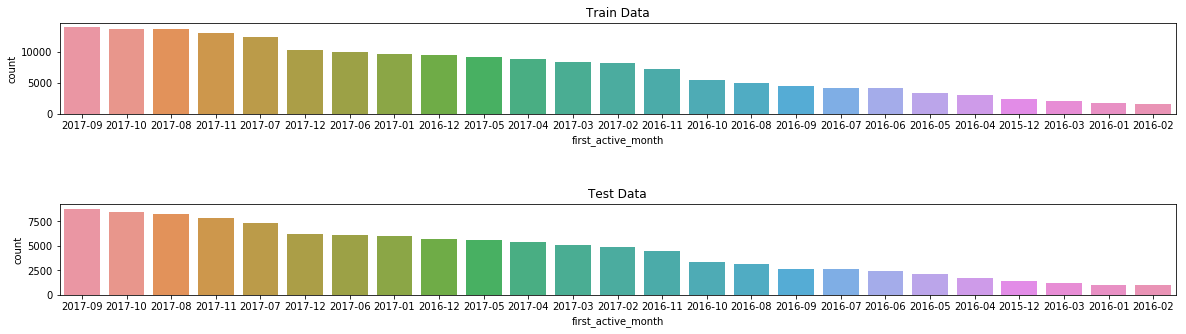

In [8]:
plt.figure(figsize=(20,5))
grid = plt.GridSpec(2, 1, wspace=0.5, hspace=1)
plt.subplot(grid[0, 0])
sns.countplot(train_data['first_active_month'],order=train_data.first_active_month.value_counts().iloc[:25].index).set_title("Train Data")
plt.subplot(grid[1, 0])
sns.countplot(test_data['first_active_month'],order=test_data.first_active_month.value_counts().iloc[:25].index).set_title("Test Data")

Majority of the customers in both train and test datasets are the ones who had their first activity post 2016. So there will be no bias wrt number of years associated with the card while predicting the customers in test dataset.Let us now look at the other three features in train and test dataset.In both the test and the train datasets we have the customers who made their first activity from 2011-Nov till end of 2017 and beggining of 2018

Lets also check if there is any relationship between 'first_active_month' and the target variables

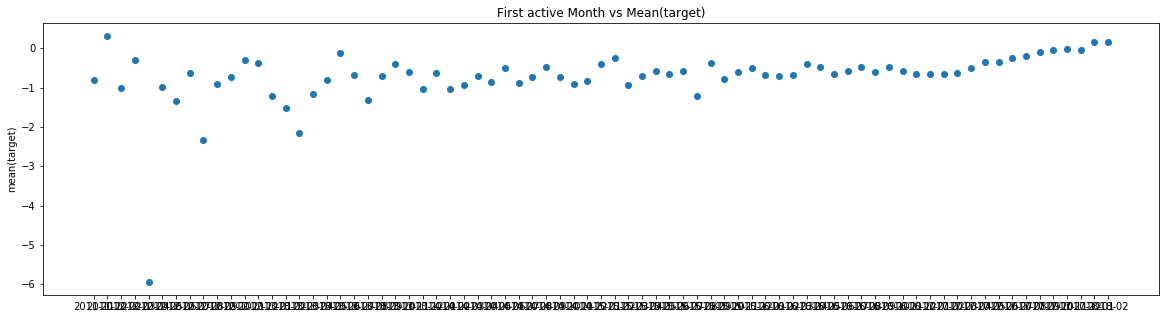

In [20]:
active_month_target=train_data[['first_active_month','target']].groupby('first_active_month').agg({'target':'mean'}).reset_index().sort_values(by='target',ascending=False)
plt.figure(figsize=(20,5))
plt.title('First active Month vs Mean(target)')
plt.ylabel('mean(target)')
plt.scatter(active_month_target['first_active_month'],active_month_target['target'])

In the above plot, we have tried to see if the mean loyalty score of a customer has any dependency on his first_active_month and looking at the plot there isnt, except for one outlier (2012-04). The number of customers who had their first active transaction is 2012-04 is anyway very less and hence we will not read too much into it.

In [21]:
train_data_copy['feature_1'].value_counts()

3    73573
2    55797
5    40625
4    19885
1    12037
Name: feature_1, dtype: int64

In [43]:
test_data_copy['feature_1'].value_counts()

3    44719
2    34115
5    25051
4    12332
1     7406
Name: feature_1, dtype: int64

In [44]:
train_data_copy['feature_2'].value_counts()

1    89242
2    74839
3    37836
Name: feature_2, dtype: int64

In [45]:
test_data_copy['feature_2'].value_counts()

1    54775
2    45993
3    22855
Name: feature_2, dtype: int64

In [46]:
train_data_copy['feature_3'].value_counts()

1    114198
0     87719
Name: feature_3, dtype: int64

In [47]:
test_data_copy['feature_3'].value_counts()

1    69770
0    53853
Name: feature_3, dtype: int64

It is not clear on what these categorical features are but all the three features seem to be ditributed in a similar ratio across the train and test datasets.Next we will see if these categorical features are at some level associated with the target variable. We will not use correlation here as correlation is strictly between continuous to continuous variable. Instead we will try to visually see if the distribution of the target variable changes with different categories of the three features. The other option is to use ANOVA on the two variables.

C:\Users\Siddi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


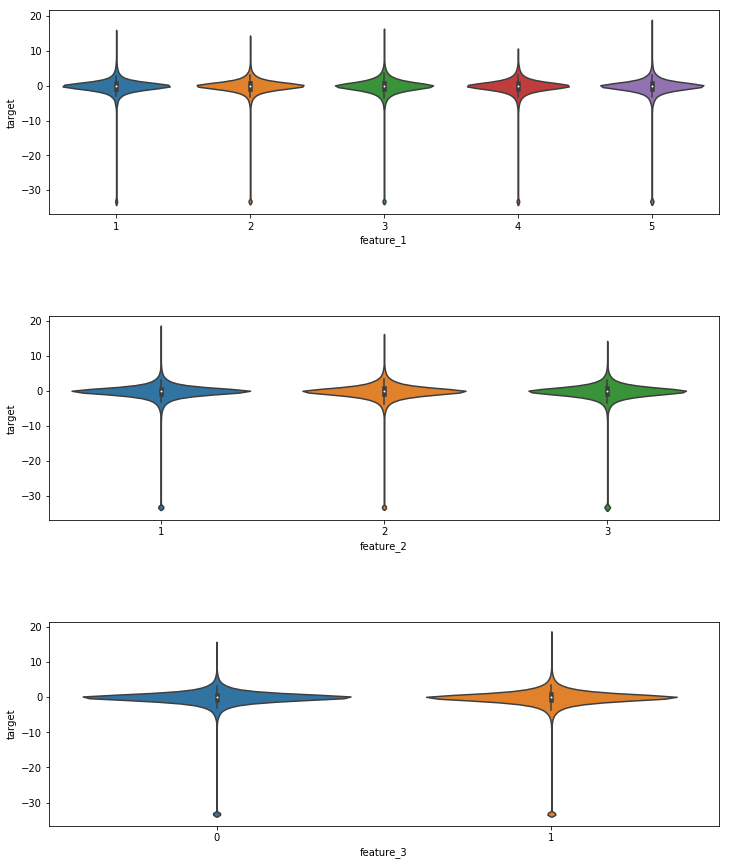

In [22]:
plt.figure(figsize=(12,15))
grid = plt.GridSpec(3, 1, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
sns.violinplot(x='feature_1',y='target',data=train_data_copy)
plt.subplot(grid[1, 0])
sns.violinplot(x='feature_2',y='target',data=train_data_copy)
plt.subplot(grid[2, 0])
sns.violinplot(x='feature_3',y='target',data=train_data_copy)

Looking at the three plots, its clear that there is no measure of associativeness between the three features and the target variable. 

Now lets try to look at the distribution of our target variable individually

C:\Users\Siddi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


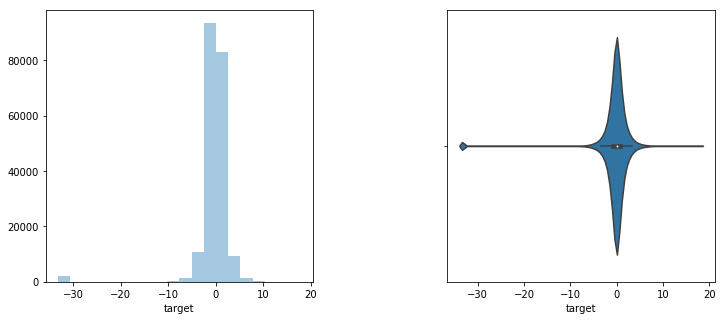

In [23]:
plt.figure(figsize=(12,5))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
sns.distplot(train_data_copy['target'],bins=20, kde=False, rug=False)
plt.subplot(grid[0, 1])
sns.violinplot(x=train_data_copy['target'])

What is interesting here are the records which are less than -30. We will now have a Closer look at those records

In [143]:
train_data_copy[train_data_copy['target']<-30].shape

(2207, 7)

In [149]:
train_data_copy[train_data_copy['target']<-30]['card_id'].nunique()

2207

There are 2207 distinct card ids for which the target values are less than -30. We will try to find the reasons for this after joining the other datasets.Let us look at the other files that we have starting with historical_transactions.

In [9]:
def get_stats(df):
    print ('Shape - ',df.shape,'\n\n')
    print ('Data types - ',df.dtypes,'\n\n')
    print ('Null values -',df.isna().sum(),'\n\n')
    print ('Authorized flags value counts -',df['authorized_flag'].value_counts(),'\n\n')
    print ('City Id Stats No of unique value -', df['city_id'].nunique(),'\n\n')
    print ('Category Id 1 Stats value counts -', df['category_1'].value_counts(),'\n\n')
    print ('Installments Stats value counts -', df['installments'].value_counts(),'\n\n')
    print ('Category Id 2 Stats value counts -', df['category_2'].value_counts(),'\n\n')
    print ('Category Id 3 Stats value counts -', df['category_3'].value_counts(),'\n\n')
    print ('Merchant_category_id unique counts -',df['merchant_category_id'].nunique(),'\n\n')
    print ('Month Lag unique counts -',df['month_lag'].value_counts(),'\n\n')
    print ('Subsector Id value counts -',df['subsector_id'].value_counts(),'\n\n')
    print ('State Id value counts -',df['state_id'].value_counts(),'\n\n')
    return

In [73]:
get_stats(historical_df)

Shape -  (29112361, 14) 


Data types -  authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object 


Null values - authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64 


Authorized flags

In [7]:
historical_df=pd.read_csv('historical_transactions.csv')

the category variables seem to be where all the null values are coming from. 

In [23]:
historical_df.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


Now lets try to get some insights about each column individually

The values look like no of monthly installments. Wonder what -1 and 999 signify! 

In [248]:
historical_df.ix[(historical_df['purchase_amount']>100) & (historical_df['authorized_flag'] == 'Y')].count()

authorized_flag         54
card_id                 54
city_id                 54
category_1              54
installments            54
category_3              53
merchant_category_id    54
merchant_id             54
month_lag               54
purchase_amount         54
purchase_date           54
category_2              53
state_id                54
subsector_id            54
dtype: int64

Lets now look at the purchase amount column

C:\Users\Siddi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


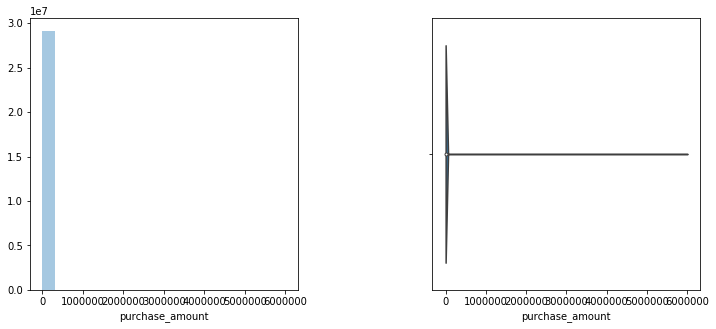

In [249]:
plt.figure(figsize=(12,5))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
_ = sns.distplot(historical_df['purchase_amount'],bins=20, kde=False, rug=False)
plt.subplot(grid[0, 1])
_ =sns.violinplot(x=historical_df['purchase_amount'])

Even though this column is normalized, there are some huge values because of which the graph appears as above. Interestingly all these high value transactions are where authorised_flag is set as N. In order to better understand and visualize the distribution of the authorized transactions, let us not consider such unathorized transactions.

C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\Siddi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


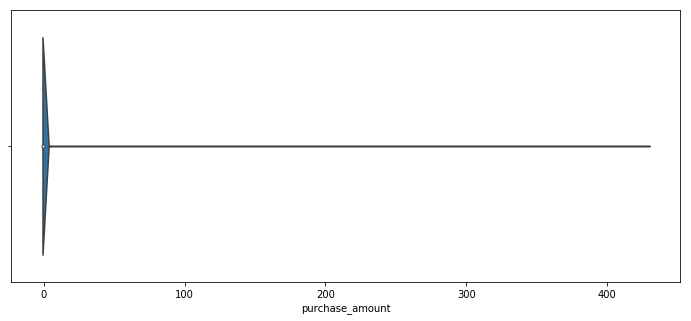

In [25]:
plt.figure(figsize=(12,5))
#grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
#plt.subplot(grid[0, 0])
#_ = sns.distplot(historical_df.ix[(historical_df['authorized_flag'] == 'Y')],bins=20, kde=False, rug=False)
#plt.subplot(grid[0, 1])
_ =sns.violinplot(x=historical_df.ix[(historical_df['authorized_flag'] == 'Y')]['purchase_amount'])

Well, this doesnt look too different compared to the previous violin plot. Lets look at the number of such records which are having a very high purchase amount.

In [35]:
high_value_transactions=historical_df.loc[(historical_df['purchase_amount'] >10)&(historical_df['authorized_flag'] == 'Y')]
high_value_transactions.count()

authorized_flag         8941
card_id                 8941
city_id                 8941
category_1              8941
installments            8941
category_3              8423
merchant_category_id    8941
merchant_id             8913
month_lag               8941
purchase_amount         8941
purchase_date           8941
category_2              6902
state_id                8941
subsector_id            8941
dtype: int64

There are 8941 transactions whose purchase_amount is > 10, there are 54 transactions whose purchase_amount is > 100, and 5 whose purchase_amount > 200.These are anomalies and I am tempted not to include these when we finalize the data to be fed into our algorithm. It is also interesting to see what would be the target scores of those cards which have made these high value transactions. Will take a call on removing these transactions after having done further analysis. 

In [36]:
high_value_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
11659,Y,C_ID_8b076210e3,69,N,3,C,68,M_ID_d13262f4b0,-7,13.188409,2017-07-09 12:50:14,1.0,9,27
11665,Y,C_ID_8b076210e3,143,N,-1,NaN,529,M_ID_ee49309db6,-4,13.175155,2017-10-07 00:00:00,5.0,5,20
13529,Y,C_ID_89f75e7d82,259,N,-1,NaN,793,M_ID_d7311727d4,-2,15.181195,2017-12-11 13:58:47,5.0,21,38
16899,Y,C_ID_c182ec51a0,17,N,6,C,198,M_ID_2abe75562c,-13,22.538490,2017-01-28 15:05:39,4.0,22,10
17188,Y,C_ID_c182ec51a0,-1,Y,1,B,879,M_ID_9139332ccc,-3,10.823506,2017-11-03 23:37:15,NaN,-1,29


In [49]:
high_value_cards=high_value_transactions['card_id'].unique()
len(high_value_cards)

5127

In [52]:
len(train_data_copy[train_data_copy['card_id'].isin( high_value_cards)])

3109

In [60]:
train_data_copy[train_data_copy['card_id'].isin(high_value_cards)]['target'].mean()

-0.3960742344097774

In [59]:
train_data_copy['target'].mean()

-0.39363629907797143

Interestingly, the mean target of the high value transaction cards is equal to the mean target value of all cards. 

In [53]:
len(test_data_copy[train_data_copy['card_id'].isin( high_value_cards)])

C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1925

In [51]:
test_data_copy[test_data_copy['card_id'].isin( train_data_copy['card_id'])].count()

card_id      0
feature_1    0
feature_2    0
feature_3    0
year         0
month        0
dtype: int64

In [78]:
historical_df['category_2'].value_counts()

1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64

In [79]:
historical_df['state_id'].nunique()

25

In [62]:
historical_df['merchant_id'].nunique()

326311

In [80]:
historical_df['subsector_id'].nunique()

41

C:\Users\Siddi\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


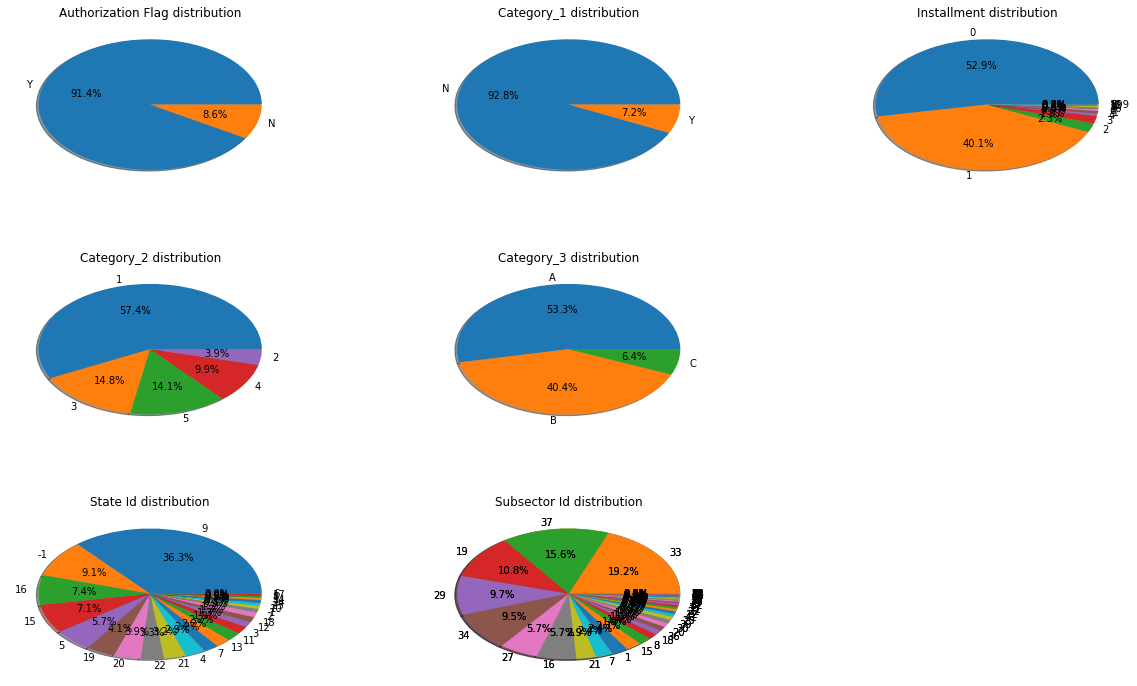

In [230]:
plt.figure(figsize=(20,12))
grid = plt.GridSpec(3, 3, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
labels=['Y','N']
plt.title('Authorization Flag distribution')
_=plt.pie(historical_df['authorized_flag'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[0, 1])
labels=['N','Y']
plt.title('Category_1 distribution')
_=plt.pie(historical_df['category_1'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[0, 2])
labels=historical_df['installments'].value_counts().index
plt.title('Installment distribution')
_=plt.pie(historical_df['installments'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[1, 0])
labels=['1','3','5','4','2']
plt.title('Category_2 distribution')
_=plt.pie(historical_df['category_2'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[1, 1])
labels=['A','B','C']
plt.title('Category_3 distribution')
_=plt.pie(historical_df['category_3'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[2, 0])
labels=historical_df['state_id'].value_counts().index
plt.title('State Id distribution')
_=plt.pie(historical_df['state_id'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[2, 1])
labels=historical_df['subsector_id'].value_counts().index
plt.title('Subsector Id distribution')
_=plt.pie(historical_df['subsector_id'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[2, 1])
labels=historical_df['subsector_id'].value_counts().index
plt.title('Subsector Id distribution')
_=plt.pie(historical_df['subsector_id'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)

Before doing Bivariate and multivariate analysis on this dataset, let us check if there are details of the customers who are in test dataset too inside historical transactions. Also, let us check if there are details in this dataset for all customers who are mentioned in train and test dataset

In [84]:
train_data_copy['card_id'].isin(historical_df['card_id']).shape

(201917,)

Looks like there are details in historical_df about all customers in train_data. Lets check the same for customers in test_data

In [85]:
test_data_copy['card_id'].isin(historical_df['card_id']).shape

(123623,)

Thankfully, same is for customers in test data as well. It would have been a nightmare if this was not the case

Since we will have to merge all these details back to the train and test datasets, it is apparent we will need to aggregate all these details at the card level and then merge it with train and test files. Some of the aggregations we can apply are:

 - No of transactions per card.
 - No of authorized transactions per card
 - No of unauthorised transactions per card
 - No of category_1 = Y transactions per card
 - No of category_1 = N transactions per card
 - Mean of installments for each card.
 - No of different types of Category_2 transactions per card 
 - No of different types of Category_3 transactions per card 
 - State_id from which most transactions have happened per card
 - subsector_id from which most transactions have happened per card
 - Mean purchase amount of authorized transactions per card
 - Max purchase amount of authorized transactions per card
 - Min purchase amount of authorized transactions per card
 - Mean Month lag(only for authorized transactions) per card
 - Likelyhood of the customer/card shopping from the same merchant_id
 - Likelyhood of the customer/card shopping from same merchant category_id and same subsector_id and from same city

Let us do all the aggregations together after exploring the other files that we have

In [11]:
new_merchants_df=pd.read_csv('new_merchant_transactions.csv')

In [12]:
new_merchants_df.shape

(1963031, 14)

In [68]:
new_merchants_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [74]:
get_stats(new_merchants_df)

Shape -  (1963031, 14) 


Data types -  authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object 


Null values - authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64 


Authorized flags value counts -

C:\Users\Siddi\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


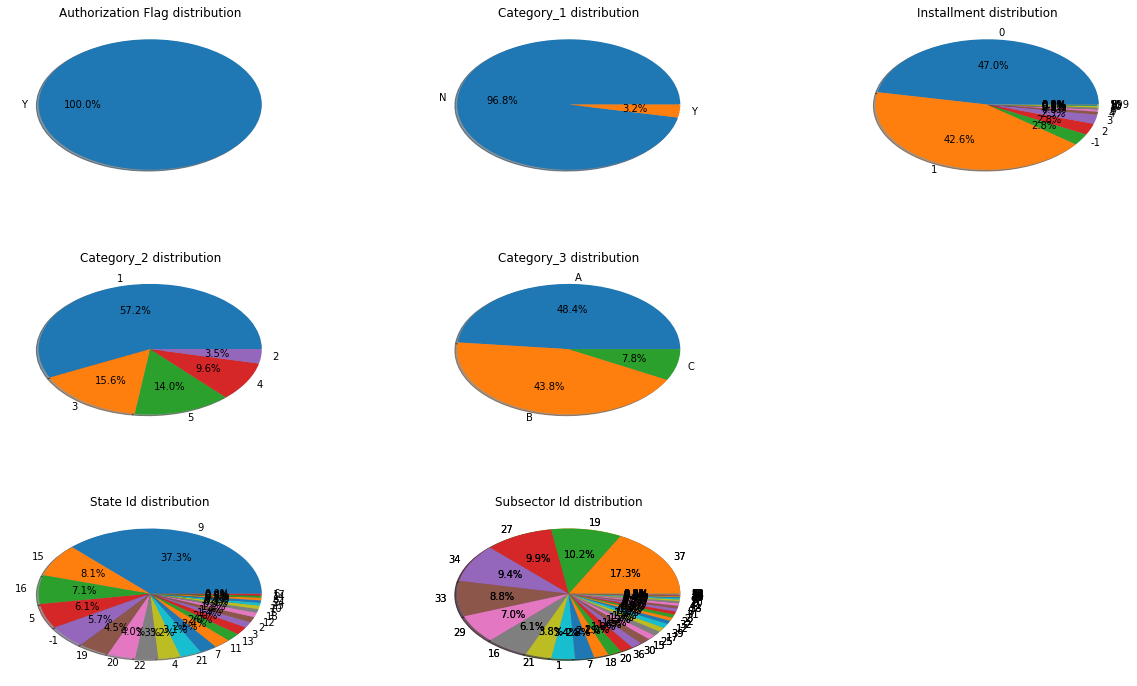

In [76]:
plt.figure(figsize=(20,12))
grid = plt.GridSpec(3, 3, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
labels=['Y']
plt.title('Authorization Flag distribution')
_=plt.pie(new_merchants_df['authorized_flag'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[0, 1])
labels=['N','Y']
plt.title('Category_1 distribution')
_=plt.pie(new_merchants_df['category_1'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[0, 2])
labels=new_merchants_df['installments'].value_counts().index
plt.title('Installment distribution')
_=plt.pie(new_merchants_df['installments'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[1, 0])
labels=['1','3','5','4','2']
plt.title('Category_2 distribution')
_=plt.pie(new_merchants_df['category_2'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[1, 1])
labels=['A','B','C']
plt.title('Category_3 distribution')
_=plt.pie(new_merchants_df['category_3'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[2, 0])
labels=new_merchants_df['state_id'].value_counts().index
plt.title('State Id distribution')
_=plt.pie(new_merchants_df['state_id'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[2, 1])
labels=new_merchants_df['subsector_id'].value_counts().index
plt.title('Subsector Id distribution')
_=plt.pie(new_merchants_df['subsector_id'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)
#
plt.subplot(grid[2, 1])
labels=new_merchants_df['subsector_id'].value_counts().index
plt.title('Subsector Id distribution')
_=plt.pie(new_merchants_df['subsector_id'].value_counts(), labels=labels,autopct='%1.1f%%',  shadow=True)

C:\Users\Siddi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


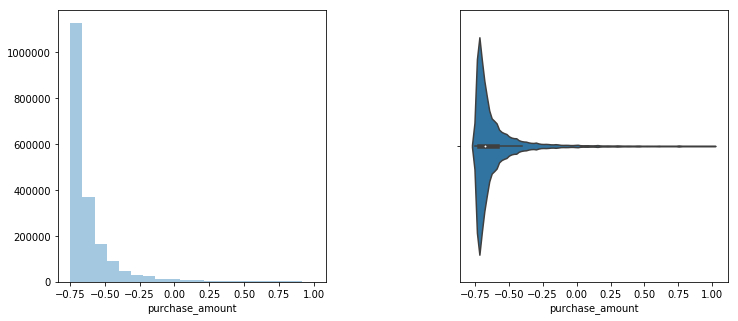

In [82]:
plt.figure(figsize=(12,5))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
_ = sns.distplot(new_merchants_df[new_merchants_df['purchase_amount']<1]['purchase_amount'],bins=20, kde=False, rug=False)
plt.subplot(grid[0, 1])
_ =sns.violinplot(x=new_merchants_df[new_merchants_df['purchase_amount']<1]['purchase_amount'])

The violin plot for the new merchant transactions look very similar to the historical transactions.

C:\Users\Siddi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


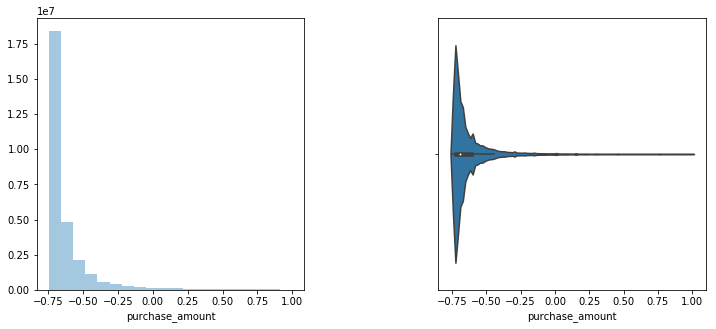

In [83]:
plt.figure(figsize=(12,5))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
_ = sns.distplot(historical_df[historical_df['purchase_amount']<1]['purchase_amount'],bins=20, kde=False, rug=False)
plt.subplot(grid[0, 1])
_ =sns.violinplot(x=historical_df[historical_df['purchase_amount']<1]['purchase_amount'])

In [8]:
merchants_df=pd.read_csv('merchants.csv')

In [24]:
merchants_df.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,active_months_lag12,category_4,city_id,state_id,category_2,Combination,Diff_purchases_3_6,Diff_purchases_6_12,Diff_sales_3_6,Diff_sales_6_12
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,12,N,242,9,1.0,EE,9.000000,4.750000,-1.85,0.07
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,12,N,22,16,1.0,EE,-0.458333,-0.395833,-0.02,-0.17
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,2,N,-1,5,5.0,EE,0.000000,0.000000,0.00,0.00
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,12,Y,-1,-1,NaN,EE,3.000000,0.833333,NaN,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,12,Y,-1,-1,NaN,EE,-0.138889,0.013889,NaN,NaN


In [20]:
merchants_df['merchant_group_id'].nunique()

109391

In [21]:
merchants_df['merchant_category_id'].nunique()

324

In [88]:
merchants_df['category_1'].value_counts()

N    327657
Y      7039
Name: category_1, dtype: int64

In [91]:
merchants_df['subsector_id'].nunique()

41

In [92]:
merchants_df['numerical_1'].nunique()

954

In [93]:
merchants_df['numerical_2'].nunique()

947

In [6]:
merchants_df['Combination']=merchants_df['most_recent_purchases_range']+merchants_df['most_recent_sales_range']

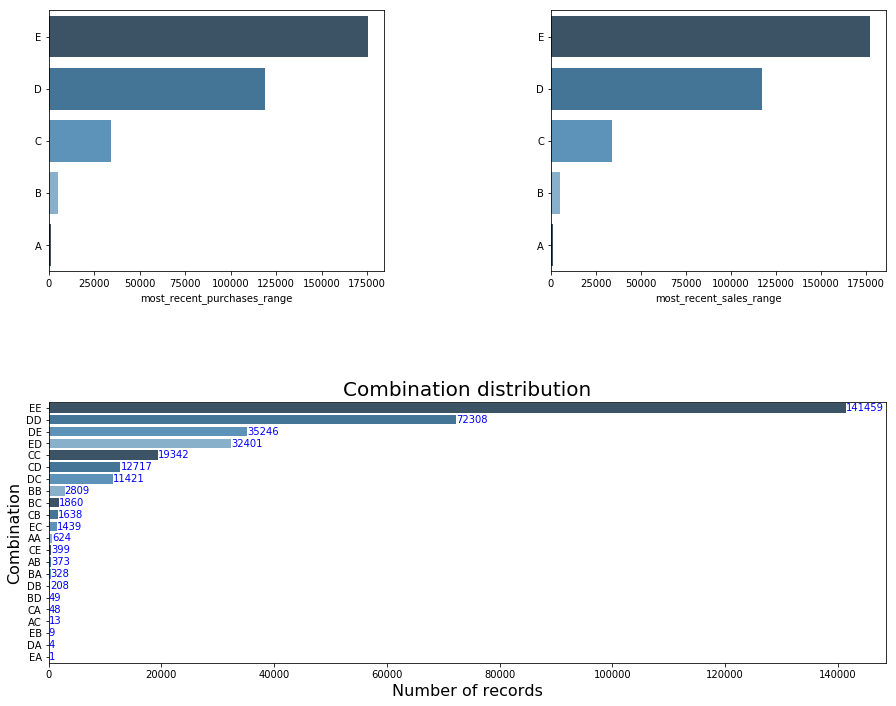

In [134]:
plt.figure(figsize=(15,12))
grid = plt.GridSpec(2, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
colors = sns.color_palette("Blues_d", 4)
sns.barplot(y = merchants_df['most_recent_purchases_range'].value_counts().index , x = merchants_df['most_recent_purchases_range'].value_counts(), orient='h', palette=colors)
#ax = sns.barplot(y = 'most_recent_purchases_range' , x = merchants_df['most_recent_purchases_range'].value_counts(),data=merchants_df,hue='most_recent_purchases_range', orient='h', palette=colors)
ax.set_xlabel(xlabel='Number of records', fontsize=16)
ax.set_ylabel(ylabel='most_recent_purchases_range', fontsize=16)
ax.set_title(label='Most recent purchases range distribution', fontsize=20)
#ax.set_yticklabels(labels = regions, fontsize=14)
plt.subplot(grid[0, 1])
sns.barplot(y = merchants_df['most_recent_sales_range'].value_counts().index , x = merchants_df['most_recent_sales_range'].value_counts(), orient='h', palette=colors)
#ax = sns.barplot(y = 'most_recent_purchases_range' , x = merchants_df['most_recent_purchases_range'].value_counts(),data=merchants_df,hue='most_recent_purchases_range', orient='h', palette=colors)
ax.set_xlabel(xlabel='Number of records', fontsize=16)
ax.set_ylabel(ylabel='most_recent_sales_range', fontsize=16)
ax.set_title(label='Most recent sales range distribution', fontsize=20)
#
plt.subplot(grid[1, :])
#add_subplot(grid[1, :])
ax = sns.barplot(y = merchants_df['Combination'].value_counts().index , x = merchants_df['Combination'].value_counts(), orient='h', palette=colors)
#ax = sns.barplot(y = 'most_recent_purchases_range' , x = merchants_df['most_recent_purchases_range'].value_counts(),data=merchants_df,hue='most_recent_purchases_range', orient='h', palette=colors)
ax.set_xlabel(xlabel='Number of records', fontsize=16)
ax.set_ylabel(ylabel='Combination', fontsize=16)
ax.set_title(label='Combination distribution', fontsize=20)
y=merchants_df['Combination'].value_counts()
for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), color='blue')
plt.show();

The first and second plots show the 'most_recent_purchases_range' and 'most_recent_sales_range' respectively. The definitions are as below:
 - most_recent_purchases_range - Range of quantity of transactions in last active month
 - most_recent_sales_range - Range of revenue in last active month.
   with A>B>C>D>E
     
    This means that merchants falling in the A bucket have had the most number of transactions and they have generated most revenues.
    Understandably, the merchants falling in A category are the smallest group. 
    Most number of merchants fall in the other end of spectrum. 
    
    Intuitevely , it is fair to suggest that the more the number of transactions a merchant makes, more will be the quantity of revenue generated and vice versa.
    In the plot in the row 2, we have tried to verify if the above statement is true. 
    
    We see that most of the vendors who fall in bucket E,D for most_purchase_range also fall in most_sales_range. We also observe that there are a few merchants which fall in the neibbhouring bucket
    
   Most interesting are the ones where we see the combinations EA and DA. These are the ones which have had the least quantity of transactions but still ended up with most revenue generated. It would be interesting to have a look at those.

In [138]:
merchants_df[(merchants_df['Combination']=='EA')|(merchants_df['Combination']=='DA')]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2,Combination
333793,M_ID_bd01e00df0,18683,210,35,-0.057471,-0.057471,Y,A,D,0.89,...,0.968254,6,0.68,0.873492,12,Y,-1,-1,NaN,DA
333958,M_ID_be119cab4d,6313,385,17,-0.047556,-0.047556,Y,A,D,0.97,...,0.934335,6,0.76,0.789953,12,Y,-1,-1,NaN,DA
334021,M_ID_9f227ee53d,17543,245,3,-0.047556,-0.057471,Y,A,D,1.08,...,1.310897,6,0.95,1.067842,12,Y,-1,-1,NaN,DA
334068,M_ID_a570b6c342,101618,210,35,-0.057471,-0.057471,Y,A,D,0.83,...,1.082596,6,0.62,0.823746,12,Y,-1,-1,NaN,DA
334532,M_ID_147bf3db6c,96016,437,15,-0.057471,-0.057471,Y,A,E,0.73,...,0.987805,6,0.36,0.613821,12,Y,-1,-1,NaN,EA


The expectation is that the mean purchase_amount of all the transactions made with these merchants are much higher than the overall mean of all transactions.

In [141]:
historical_df[historical_df['merchant_id']=='M_ID_147bf3db6c']['purchase_amount'].mean()

5.227404360882352

In [157]:
new_merchants_df[new_merchants_df['merchant_id']=='M_ID_147bf3db6c']['purchase_amount'].mean()

nan

In [142]:
historical_df[historical_df['merchant_id']=='M_ID_a570b6c342']['purchase_amount'].mean()

6.171274324594594

In [143]:
historical_df[historical_df['merchant_id']=='M_ID_9f227ee53d']['purchase_amount'].mean()

6.816532025752812

In [144]:
historical_df[historical_df['merchant_id']=='M_ID_be119cab4d']['purchase_amount'].mean()

2.94641335917222

In [145]:
historical_df[historical_df['merchant_id']=='M_ID_bd01e00df0']['purchase_amount'].mean()

2.2572180832936506

In [147]:
historical_df['purchase_amount'].mean()

0.03640090136488929

However, we already saw that higher transaction amount might not necessarily translate to higher/lower target values in the train dataset.

Let us create a few additional features here to get some insights out of sales and purchasing columns in the merchants data.
We will create features to indicate if the sales and purchasing trends are on the increasing trend or decreasing trend

In [9]:
merchants_df['Diff_purchases_3_6']=merchants_df['avg_purchases_lag6']-merchants_df['avg_purchases_lag3']
merchants_df['Diff_purchases_6_12']=merchants_df['avg_purchases_lag6']-merchants_df['avg_purchases_lag12']
merchants_df['Diff_sales_3_6']=merchants_df['avg_sales_lag6']-merchants_df['avg_sales_lag3']
merchants_df['Diff_sales_6_12']=merchants_df['avg_sales_lag6']-merchants_df['avg_sales_lag12']

In [181]:
len(merchants_df[(merchants_df['Diff_purchases_6_12']>0)&(merchants_df['Diff_purchases_3_6']>0)])

68537

68537 merchants whose quantity of purchases are consistently on an increasing trend

In [188]:
len(merchants_df[(merchants_df['Diff_sales_6_12']>0)&(merchants_df['Diff_sales_3_6']>0)])

61450

61450 merchants whose sales/revenue are on an upward trend

In [183]:
len(merchants_df[(merchants_df['Diff_purchases_6_12']>0)&(merchants_df['Diff_purchases_3_6']>0)&(merchants_df['Diff_sales_6_12']>0)&(merchants_df['Diff_sales_3_6']>0)])

40640

40640 merchants whose quantity of purchases and sales/revenue both are consistently on an increasing trend.

In [184]:
len(merchants_df[(merchants_df['Diff_purchases_6_12']>0)&(merchants_df['Diff_purchases_3_6']>0)&(merchants_df['Diff_sales_6_12']<0)&(merchants_df['Diff_sales_3_6']<0)])

2299

2299 merchants whose quantity of purchases is increasing consistently but sales/revenue is decreasing while that happens.

In [186]:
len(merchants_df[(merchants_df['Diff_purchases_6_12']<0)&(merchants_df['Diff_purchases_3_6']<0)&(merchants_df['Diff_sales_6_12']>0)&(merchants_df['Diff_sales_3_6']>0)])

1636

1636 merchants whose quantity of purchases is decreasing consistently but sales/revenue is increasing while that happens.

In [24]:
cat_id_avg_sales=merchants_df[['merchant_category_id','avg_sales_lag3']].groupby(['merchant_category_id']).agg({'avg_sales_lag3':{'mean': 'mean', 'count': 'count'}}).reset_index()
cat_id_avg_purchases=merchants_df[['merchant_category_id','avg_purchases_lag3']].groupby(['merchant_category_id']).agg({'avg_purchases_lag3':{'mean': 'mean', 'count': 'count'}}).reset_index()

C:\Users\Siddi\Anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [25]:
cat_id_avg_sales.columns = ['Cat_Id', 'mean_sales', 'count_merchants']
cat_id_avg_purchases.columns = ['Cat_Id', 'mean_purchases', 'count_merchants']

In [249]:
cat_id_avg_sales[cat_id_avg_sales['mean_sales']>10]

,Cat_Id,mean_sales,count_merchants
1,2,61.860423,1228
38,109,18.987000,10
54,162,33.863333,3
90,261,10.283220,59
98,278,21.350001,17992
103,298,52.775332,2138
105,302,5041.838343,169
107,309,250.811624,2482
128,360,47.335680,2162
162,437,61.337629,3441


In order to understand if there is some kind of trend between the mean sales and the number of merchants belonging to a particular caeogry, I have not included the rows shown above in the plot below. However, there is no descernable pattern seen

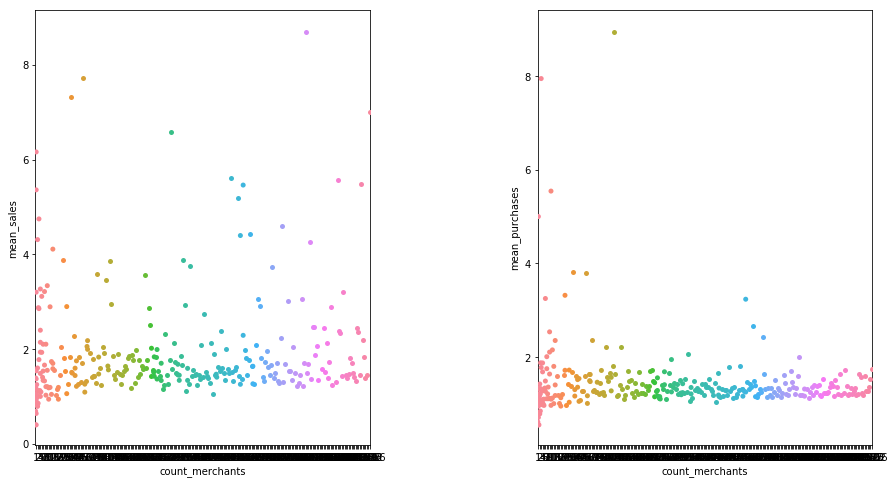

In [26]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(15,8))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
sns.swarmplot(x=cat_id_avg_sales['count_merchants'], y=cat_id_avg_sales[cat_id_avg_sales['mean_sales']<10]['mean_sales'])
plt.subplot(grid[0, 1])
sns.swarmplot(x=cat_id_avg_purchases['count_merchants'], y=cat_id_avg_purchases[cat_id_avg_purchases['mean_purchases']<10]['mean_purchases'])

Lets try to see if there are some observable patterns between the merchants belonging to a particular subsector and the avg_sales and avg_purchases

C:\Users\Siddi\Anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


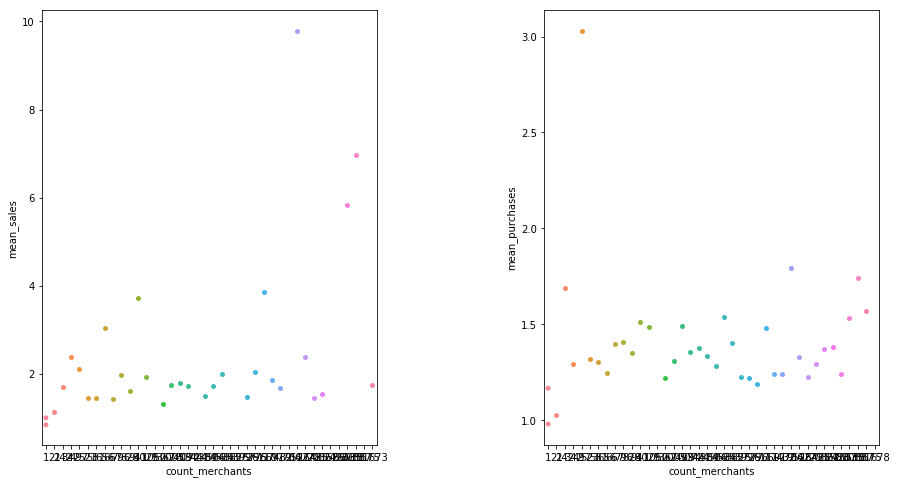

In [27]:
subsector_id_avg_sales=merchants_df[['subsector_id','avg_sales_lag3']].groupby(['subsector_id']).agg({'avg_sales_lag3':{'mean': 'mean', 'count': 'count'}}).reset_index()
subsector_id_avg_purchases=merchants_df[['subsector_id','avg_purchases_lag3']].groupby(['subsector_id']).agg({'avg_purchases_lag3':{'mean': 'mean', 'count': 'count'}}).reset_index()
subsector_id_avg_sales.columns = ['Subsector_Id', 'mean_sales', 'count_merchants']
subsector_id_avg_purchases.columns = ['Subsector_Id', 'mean_purchases', 'count_merchants']
#
fig = plt.figure(figsize=(15,8))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[0, 0])
sns.swarmplot(x=subsector_id_avg_sales['count_merchants'], y=subsector_id_avg_sales[subsector_id_avg_sales['mean_sales']<10]['mean_sales'])
plt.subplot(grid[0, 1])
sns.swarmplot(x=subsector_id_avg_purchases['count_merchants'], y=subsector_id_avg_purchases[subsector_id_avg_purchases['mean_purchases']<10]['mean_purchases'])

Like before, let us not consider the the rows where mean sales and purchase values are > 10. THe ones which are not in the plot are shown below

In [270]:
subsector_id_avg_sales[subsector_id_avg_sales['mean_sales']>10]

,Subsector_Id,mean_sales,count_merchants
6,7,58.820253,7706
9,10,27.036859,5399
14,15,61.337629,3441
20,21,29.039240,24206
21,22,813.216762,1050
28,29,47.400694,21586
35,36,10.119033,4882
36,37,11.969470,35575


In [271]:
subsector_id_avg_purchases[subsector_id_avg_purchases['mean_purchases']>10]

,Subsector_Id,mean_purchases,count_merchants
21,22,60.246170,1050
26,27,inf,51678


C:\Users\Siddi\Anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


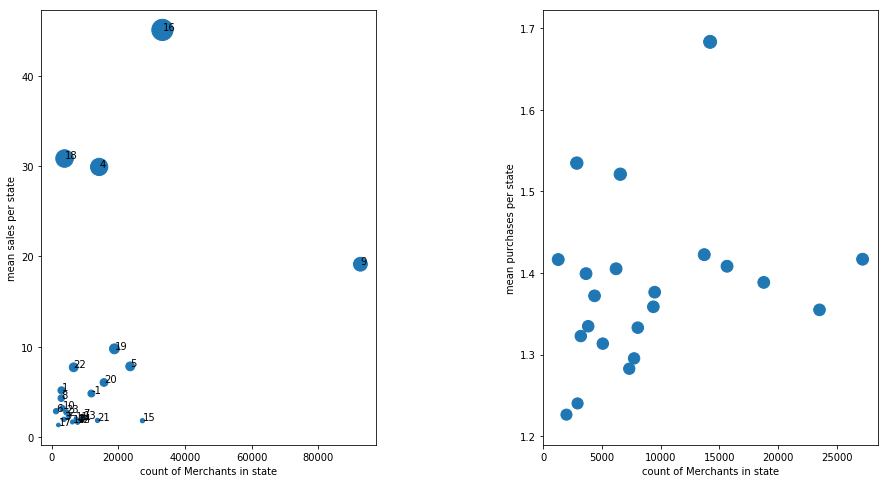

In [41]:
state_id_avg_sales=merchants_df[['state_id','avg_sales_lag3']].groupby(['state_id']).agg({'avg_sales_lag3':{'mean': 'mean', 'count': 'count'}}).reset_index()
state_id_avg_purchases=merchants_df[['state_id','avg_purchases_lag3']].groupby(['state_id']).agg({'avg_purchases_lag3':{'mean': 'mean', 'count': 'count'}}).reset_index()
state_id_avg_sales.columns = ['state_Id', 'mean_sales', 'count_merchants']
state_id_avg_purchases.columns = ['state_Id', 'mean_purchases', 'count_merchants']
#
s = [10*i for i in state_id_avg_sales['mean_sales']]
fig = plt.figure(figsize=(15,8))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax=plt.subplot(grid[0, 0])
x=state_id_avg_sales['count_merchants']
y=state_id_avg_sales['mean_sales']
ax.scatter(state_id_avg_sales['count_merchants'], state_id_avg_sales['mean_sales'],s=s, cmap="Blues")
plt.xlabel('count of Merchants in state')
plt.ylabel('mean sales per state')
for i, txt in enumerate(state_id_avg_sales['state_Id']):
    ax.annotate(txt, (x[i], y[i]))
ax1=plt.subplot(grid[0, 1])
s = [100*i for i in state_id_avg_purchases['mean_purchases']]
x=state_id_avg_purchases['count_merchants']
y=state_id_avg_purchases[state_id_avg_purchases['mean_purchases']<100]['mean_purchases']
plt.xlabel('count of Merchants in state')
plt.ylabel('mean purchases per state')
ax1.scatter(state_id_avg_purchases['count_merchants'], state_id_avg_purchases['mean_purchases'],s=s, cmap="Blues")
#sns.lmplot(x=state_id_avg_purchases['count_merchants'], y=state_id_avg_purchases[state_id_avg_purchases['mean_purchases']<10]['mean_purchases'])

## Aggregating from merchants to historical and new merchants dataframe

In [52]:
result = pd.merge(new_merchants_df, merchants_df, how='left', on='merchant_id')

In [43]:
new_merchants_df.shape

(1963031, 14)

In [44]:
merchants_df.shape

(334696, 27)

In [53]:
result.shape

(1994895, 40)

Number of rows in our result dataframe has increased after doing the merge.It looks like there are some duplicates in the new_merchants df.

In [89]:
result = pd.merge(new_merchants_df, merchants_df, how='left', on=['merchant_id','merchant_category_id','state_id','city_id','category_2','category_1','subsector_id'])

In [90]:
result.shape

(1969033, 34)

Well, it looks like the duplicates are not in new_merchants_df but in merchants_df. Let us figure out which those duplicates records are

In [116]:
test=merchants_df.drop_duplicates(subset=['merchant_id','merchant_group_id'])
test.shape

(334645, 27)

In [117]:
extras= pd.concat([merchants_df,test]).drop_duplicates(keep=False)

In [120]:
extras

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,active_months_lag12,category_4,city_id,state_id,category_2,Combination,Diff_purchases_3_6,Diff_purchases_6_12,Diff_sales_3_6,Diff_sales_6_12
54,M_ID_c0b712e11a,35,823,25,-0.007896,-0.007896,N,E,E,1.01,...,12,N,231,9,1.0,EE,0.146502,-0.093621,0.00,-0.19
112,M_ID_0039220eb3,35,836,5,0.408530,0.408530,Y,C,D,1.17,...,12,Y,-1,-1,NaN,DC,-0.021711,0.090917,0.00,-0.02
3394,M_ID_bd49e37dda,35,692,21,-0.057471,-0.057471,N,D,E,1.35,...,6,N,51,16,1.0,ED,0.020000,0.000000,-0.12,0.00
3395,M_ID_bd49e37dda,4170,692,21,-0.057471,-0.057471,N,D,E,1.35,...,6,N,51,16,1.0,ED,0.020000,0.000000,-0.12,0.00
4183,M_ID_ef233cff26,28799,560,34,-0.057471,-0.057471,N,D,D,4.74,...,8,Y,69,9,1.0,DD,0.096320,0.664502,0.24,0.73
4184,M_ID_ef233cff26,35,560,34,-0.057471,-0.057471,N,D,D,4.74,...,8,Y,69,9,1.0,DD,0.096320,0.664502,0.24,0.73
7586,M_ID_dbbf07ebf0,69462,278,37,-0.047556,-0.047556,N,D,D,1.12,...,12,Y,17,22,4.0,DD,0.101064,-0.078457,0.11,-0.07
7587,M_ID_dbbf07ebf0,35,278,37,-0.047556,-0.047556,N,D,D,1.12,...,12,Y,17,22,4.0,DD,0.101064,-0.078457,0.11,-0.07
8173,M_ID_0c4018d3a0,35,879,29,-0.057471,-0.057471,N,E,D,0.51,...,2,Y,246,1,3.0,DE,0.000000,0.000000,0.00,0.00
8418,M_ID_c470fbcfb9,35,574,22,1.885851,1.885851,Y,C,C,1.02,...,12,Y,-1,-1,NaN,CC,0.124935,-0.097489,0.14,-0.03


So, these are the duplicated records, the difference is only in the merchant_group_id column. I do not prefer to merge these to new_merchants_df and historical_df. Instead, i will keep only the first instance and drop the second from merchants_df

In [10]:
merchants_df=merchants_df.drop_duplicates(subset=['merchant_id','merchant_group_id'],keep='first')

In [25]:
merchants_df.shape

(334645, 27)

In [123]:
result = pd.merge(new_merchants_df, merchants_df, how='left', on=['merchant_id','merchant_category_id','state_id','city_id','category_2','category_1','subsector_id'])

In [124]:
result.shape

(1963943, 34)

It seems, like we still ended up with 900 more records in our merged dataframe. I will proceed for now and revisit the rootcause once I have the basic model ready.

In [449]:
historical_df.isna().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

In [15]:
result_hist[result_hist['merchant_group_id'].isnull()][['merchant_id','subsector_id']].head()

,merchant_id,merchant_category_id,subsector_id
11,M_ID_7c5e93af2f,560,34
16,M_ID_00a6ca8a8a,879,29
23,M_ID_e020e9b302,278,37
26,M_ID_e020e9b302,278,37
41,M_ID_e020e9b302,278,37


In [19]:
merchants_df.shape

(334645, 27)

In [20]:
merchants_df['merchant_id'].nunique()

334633

In [450]:
merchants_df.isna().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11867
Combination                        0
Diff_purchases_3_6                 3
Diff_purchases_6_12                3
Diff_sales_3_6                    13
Diff_sales_6_12                   13
d

In [11]:
result_hist = pd.merge(historical_df, merchants_df, how='left', on=['merchant_id'])

In [24]:
result_hist['merchant_group_id'].isna().sum()

138481

Here, we ended up with ~9k extra records in after we merged the merchants_df to historical_df. Again due to some undetected duplicates in merchants_df. We will revisit this at a later point of time

In [19]:
result_hist.columns

Index(['authorized_flag', 'card_id', 'city_id_x', 'category_1_x',
       'installments', 'category_3', 'merchant_category_id_x', 'merchant_id',
       'month_lag', 'purchase_amount', 'purchase_date', 'category_2_x',
       'state_id_x', 'subsector_id_x', 'merchant_group_id',
       'merchant_category_id_y', 'subsector_id_y', 'numerical_1',
       'numerical_2', 'category_1_y', 'most_recent_sales_range',
       'most_recent_purchases_range', 'avg_sales_lag3', 'avg_purchases_lag3',
       'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6',
       'active_months_lag6', 'avg_sales_lag12', 'avg_purchases_lag12',
       'active_months_lag12', 'category_4', 'city_id_y', 'state_id_y',
       'category_2_y', 'Combination'],
      dtype='object')

In [12]:
result_hist['compare_cities']=result_hist['city_id_x'].equals(result_hist['city_id_y'])

In [26]:
result_hist.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'merchant_group_id', 'numerical_1', 'numerical_2',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'Combination', 'Diff_purchases_3_6',
       'Diff_purchases_6_12', 'Diff_sales_3_6', 'Diff_sales_6_12'],
      dtype='object')

In [13]:
result_hist=result_hist.drop(['merchant_category_id_y','subsector_id_y','category_1_y','city_id_y','state_id_y','category_2_y','compare_cities'],axis=1)

In [14]:
import gc
gc.collect()

84

In [15]:
result_hist.rename(columns={'city_id_x':'city_id','category_1_x':'category_1','merchant_category_id_x':'merchant_category_id','category_2_x':'category_2','state_id_x':'state_id','subsector_id_x':'subsector_id'},inplace=True)

In [176]:
result_hist.isna().sum()

authorized_flag                      0
card_id                              0
city_id                              0
category_1                           0
installments                         0
category_3                      178175
merchant_category_id                 0
merchant_id                     138481
month_lag                            0
purchase_amount                      0
purchase_date                        0
category_2                     2659360
state_id                             0
subsector_id                         0
merchant_group_id               138481
numerical_1                     138481
numerical_2                     138481
most_recent_sales_range         138481
most_recent_purchases_range     138481
avg_sales_lag3                  147548
avg_purchases_lag3              138481
active_months_lag3              138481
avg_sales_lag6                  147548
avg_purchases_lag6              138481
active_months_lag6              138481
avg_sales_lag12          

Now, to do some EDA on the merged datasets

 - most_recent_purchases_range vs installments
 - most_recent_sales_range vs installments

In [175]:
group_sales_installment=result_hist[['most_recent_sales_range','installments','card_id']].groupby(['most_recent_sales_range','installments']).agg({'card_id':'count'})

In [186]:
group_sales_installment_pct = group_sales_installment.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

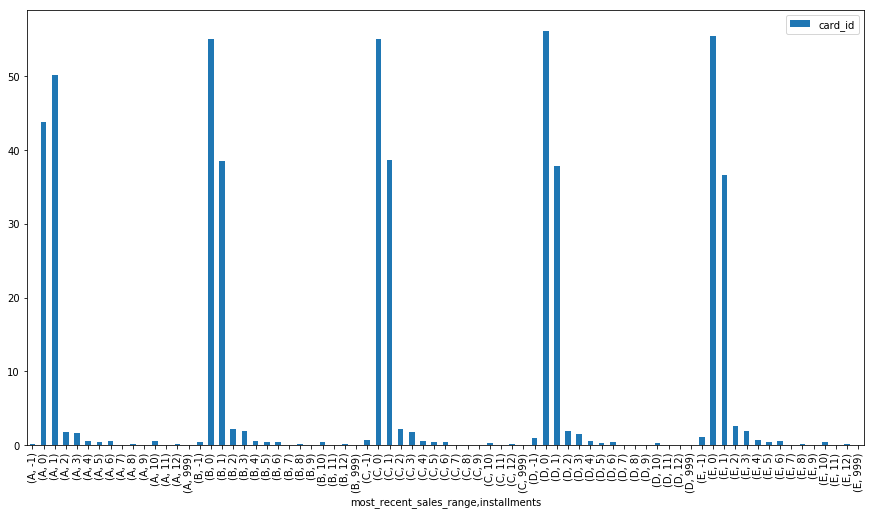

In [187]:
group_sales_installment_pct.plot(kind="bar", 
                 figsize=(15,8),
                 stacked=True)

Trend is similar across all 5 groups (A,B,C,D & E) of sales. However, for group A, we see that percentages of 0 installments is atleast 10% points less compared to other groups. Same trend is visible for number of purchases as well

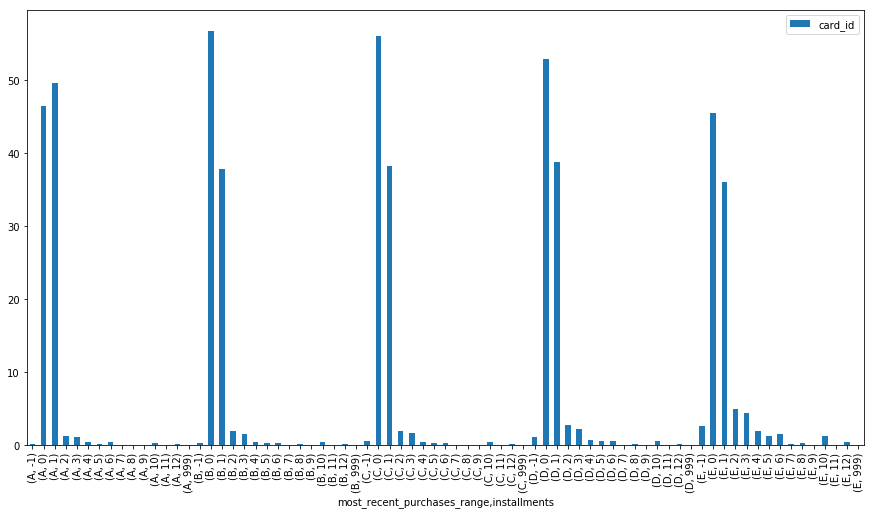

In [188]:
group_purchases_installment=result_hist[['most_recent_purchases_range','installments','card_id']].groupby(['most_recent_purchases_range','installments']).agg({'card_id':'count'})
group_purchases_installment = group_purchases_installment.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
group_purchases_installment.plot(kind="bar", 
                 figsize=(15,8),
                 stacked=True)

Lets see if the trends are similar in new merchant transactions as well.

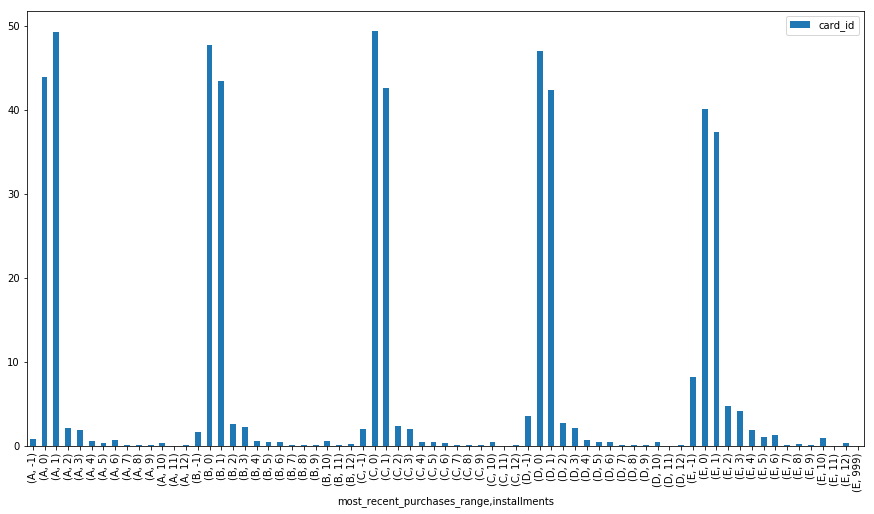

In [190]:
group_sales_installment=result[['most_recent_purchases_range','installments','card_id']].groupby(['most_recent_purchases_range','installments']).agg({'card_id':'count'})
group_sales_installment = group_purchases_installment.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
group_sales_installment.plot(kind="bar", 
                 figsize=(15,8),
                 stacked=True)

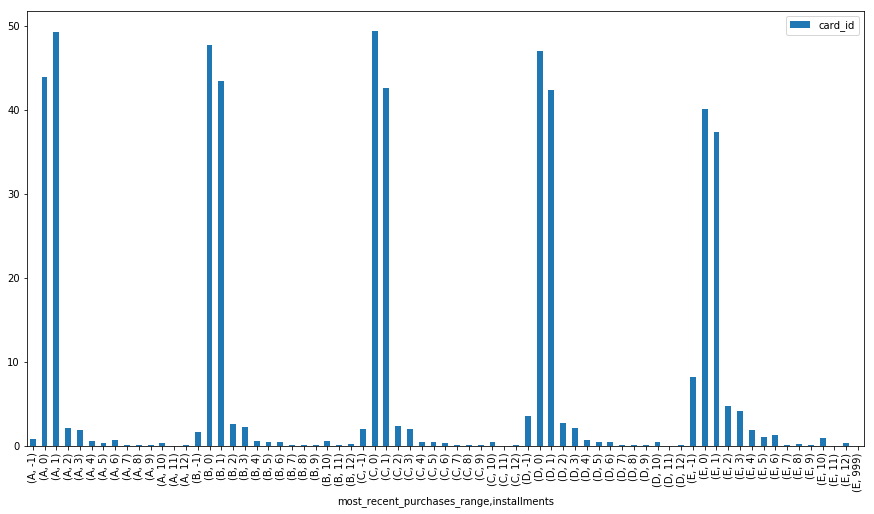

In [189]:
group_purchases_installment=result[['most_recent_purchases_range','installments','card_id']].groupby(['most_recent_purchases_range','installments']).agg({'card_id':'count'})
group_purchases_installment = group_purchases_installment.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
group_purchases_installment.plot(kind="bar", 
                 figsize=(15,8),
                 stacked=True)

## Additional feature Creation

No of transactions per card.

In [16]:
final_hist_trans=result_hist[['card_id','authorized_flag','merchant_id']].groupby(['card_id','authorized_flag']).agg({'merchant_id':'count'})
final_hist_trans=final_hist_trans.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans_y=final_hist_trans[final_hist_trans['authorized_flag']=='Y']
final_hist_trans_y=final_hist_trans_y.drop(['authorized_flag'],axis=1)
final_hist_trans_y=final_hist_trans_y.rename(columns={'merchant_id':'percent_unauth_trans'})
final_hist_trans=result_hist[['card_id','city_id']].groupby(['card_id'])
card_city=pd.DataFrame(final_hist_trans.city_id.nunique().reset_index())
final_hist_trans_y=final_hist_trans_y.merge(card_city,on='card_id')
final_hist_trans=result_hist[['card_id','city_id']].groupby(['card_id']).agg({'city_id':'count'}).reset_index().rename(columns={'city_id':'No of Transactions'})
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,on='card_id')
final_hist_trans=result_hist[['card_id','category_1','merchant_id']].groupby(['card_id','category_1']).agg({'merchant_id':'count'})
final_hist_trans=final_hist_trans.reset_index().sort_values('merchant_id', ascending=False).drop_duplicates(['card_id','category_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,on='card_id').rename(columns={'category_1':'freq_category_1','merchant_id':'cat_1_count'})
final_hist_trans=result_hist[['card_id','installments']].groupby(['card_id']).agg({'installments':'mean'}).reset_index()
final_hist_trans.head()

,card_id,installments
0,C_ID_00007093c1,1.288591
1,C_ID_0001238066,1.609756
2,C_ID_0001506ef0,0.015152
3,C_ID_0001793786,0.023148
4,C_ID_000183fdda,1.833333


In [17]:
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,on='card_id').rename(columns={'installments':'mean_installments'})
final_hist_trans=result_hist[['card_id','category_3','merchant_id']].groupby(['card_id','category_3']).agg({'merchant_id':'count'})
final_hist_trans=final_hist_trans.reset_index().sort_values('merchant_id', ascending=False).drop_duplicates(['card_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,on='card_id').rename(columns={'category_3':'freq_category_3','merchant_id':'cat_3_count'})
final_hist_trans=result_hist[['card_id','merchant_category_id','merchant_id']].groupby(['card_id','merchant_category_id']).agg({'merchant_id':'count'})
final_hist_trans=final_hist_trans.reset_index().sort_values('merchant_id', ascending=False).drop_duplicates(['card_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,on='card_id').rename(columns={'merchant_category_id':'freq_mer_cat','merchant_id':'mer_cat_count'})
final_hist_trans=result_hist[['card_id','merchant_category_id']].groupby(['card_id'])
card_city=pd.DataFrame(final_hist_trans.merchant_category_id.nunique().reset_index())
final_hist_trans_y=final_hist_trans_y.merge(card_city,on='card_id').rename(columns={'merchant_category_id':'no_of_mer_cat'})
final_hist_trans=result_hist[['card_id','merchant_id']].groupby(['card_id'])
card_city=pd.DataFrame(final_hist_trans.merchant_id.nunique().reset_index())
final_hist_trans_y=final_hist_trans_y.merge(card_city,on='card_id').rename(columns={'merchant_id':'no_of_merchants'})


In [18]:
final_hist_trans=result_hist[['card_id','merchant_id','merchant_category_id']].groupby(['card_id','merchant_id']).agg({'merchant_category_id':'count'})
final_hist_trans=final_hist_trans.reset_index().sort_values('merchant_category_id', ascending=False).drop_duplicates(['card_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,on='card_id').rename(columns={'merchant_id':'freq_merchant','merchant_category_id':'freq_merch_count'})
final_hist_trans=result_hist[['card_id','month_lag']].groupby(['card_id']).agg({'month_lag':'mean'}).reset_index()
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,on='card_id').rename(columns={'month_lag':'mean_month_lag'})
final_hist_trans=result_hist[['card_id','purchase_amount']].groupby(['card_id']).agg({'purchase_amount':'mean'}).reset_index()
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,on='card_id').rename(columns={'purchase_amount':'mean_purchase_amount'})
final_hist_trans=result_hist[['card_id','purchase_amount']].sort_values('purchase_amount', ascending=False).drop_duplicates(['card_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,on='card_id').rename(columns={'purchase_amount':'max_purchase_amount'})
final_hist_trans=result_hist[['card_id','category_2','merchant_id']].groupby(['card_id','category_2']).agg({'merchant_id':'count'})
final_hist_trans=final_hist_trans.reset_index().sort_values('merchant_id', ascending=False).drop_duplicates(['card_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'category_2':'freq_category_2','merchant_id':'cat_2_count'})
final_hist_trans=result_hist[['card_id','state_id']].groupby(['card_id'])
card_city=pd.DataFrame(final_hist_trans.state_id.nunique().reset_index())
final_hist_trans_y=final_hist_trans_y.merge(card_city,on='card_id').rename(columns={'state_id':'No_Of_states'})

In [19]:
final_hist_trans=result_hist[['card_id','subsector_id']].groupby(['card_id'])
card_city=pd.DataFrame(final_hist_trans.subsector_id.nunique().reset_index())
final_hist_trans_y=final_hist_trans_y.merge(card_city,on='card_id').rename(columns={'subsector_id':'No_Of_subsectors'})
final_hist_trans=result_hist[['card_id','merchant_group_id']].groupby(['card_id'])
card_city=pd.DataFrame(final_hist_trans.merchant_group_id.nunique().reset_index())
final_hist_trans_y=final_hist_trans_y.merge(card_city,on='card_id').rename(columns={'merchant_group_id':'no_of_merchant_groups'})
final_hist_trans=result_hist[['card_id','merchant_group_id','merchant_category_id']].groupby(['card_id','merchant_group_id']).agg({'merchant_category_id':'count'})
final_hist_trans=final_hist_trans.reset_index().sort_values('merchant_category_id', ascending=False).drop_duplicates(['card_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'merchant_group_id':'freq_merchant_group','merchant_category_id':'freq_merch_group_count'})


In [20]:
final_hist_trans_y=final_hist_trans_y.fillna(-1)

In [156]:
final_hist_trans_y.columns

Index(['card_id', 'percent_unauth_trans', 'city_id', 'No of Transactions',
       'freq_category_1', 'cat_1_count', 'mean_installments',
       'freq_category_3', 'cat_3_count', 'freq_mer_cat', 'mer_cat_count',
       'no_of_mer_cat', 'no_of_merchants', 'freq_merchant', 'freq_merch_count',
       'mean_month_lag', 'mean_purchase_amount', 'max_purchase_amount',
       'freq_category_2', 'cat_2_count', 'No_Of_states', 'No_Of_subsectors',
       'no_of_merchant_groups', 'freq_merchant_group',
       'freq_merch_group_count'],
      dtype='object')

In [21]:
final_hist_trans_y['pct_fav_merch_trans']=(final_hist_trans_y['freq_merch_count']*100)/final_hist_trans_y['No of Transactions']
final_hist_trans_y['pct_fav_merch_trans']=(final_hist_trans_y['freq_merch_count']*100)/final_hist_trans_y['No of Transactions']
final_hist_trans_y['pct_fav_merch_grp_trans']=(final_hist_trans_y['freq_merch_group_count']*100)/final_hist_trans_y['No of Transactions']

In [22]:
gc.collect()

528

In [23]:
final_hist_trans=result_hist[['card_id','merchant_category_id','authorized_flag']].groupby(['card_id','merchant_category_id']).agg({'authorized_flag':'count'})
final_hist_trans=final_hist_trans.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans=final_hist_trans.sort_values('authorized_flag', ascending=False).drop_duplicates(['card_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'merchant_category_id':'fav_merchant_category','authorized_flag':'fav_merch_category_pct'})
final_hist_trans=result_hist[['card_id','most_recent_sales_range','authorized_flag']].groupby(['card_id','most_recent_sales_range']).agg({'authorized_flag':'count'})
final_hist_trans=final_hist_trans.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans=final_hist_trans.sort_values('authorized_flag', ascending=False).drop_duplicates(['card_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'most_recent_sales_range':'fav_merchant_sales_range','authorized_flag':'fav_merch_sales_range_pct'})
final_hist_trans=result_hist[['card_id','most_recent_purchases_range','authorized_flag']].groupby(['card_id','most_recent_purchases_range']).agg({'authorized_flag':'count'})
final_hist_trans=final_hist_trans.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans=final_hist_trans.sort_values('authorized_flag', ascending=False).drop_duplicates(['card_id'])
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'most_recent_purchases_range':'fav_merchant_purchases_range','authorized_flag':'fav_merch_purchases_range_pct'})
final_hist_trans=result_hist[['card_id','avg_sales_lag3']].groupby(['card_id']).agg({'avg_sales_lag3':'mean'})
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'avg_sales_lag3':'all_merchants_sales_lag3'})
final_hist_trans=result_hist[['card_id','avg_purchases_lag3']].groupby(['card_id']).agg({'avg_purchases_lag3':'mean'})
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'avg_purchases_lag3':'all_merchants_purchases_lag3'})
final_hist_trans=result_hist[['card_id','avg_purchases_lag6']].groupby(['card_id']).agg({'avg_purchases_lag6':'mean'})
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'avg_purchases_lag6':'all_merchants_purchases_lag6'})
final_hist_trans=result_hist[['card_id','avg_sales_lag6']].groupby(['card_id']).agg({'avg_sales_lag6':'mean'})
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'avg_sales_lag6':'all_merchants_sales_lag6'})
final_hist_trans=result_hist[['card_id','avg_sales_lag12']].groupby(['card_id']).agg({'avg_sales_lag12':'mean'})
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'avg_sales_lag12':'all_merchants_sales_lag12'})
final_hist_trans=result_hist[['card_id','avg_purchases_lag12']].groupby(['card_id']).agg({'avg_purchases_lag12':'mean'})
final_hist_trans=final_hist_trans.reset_index()
final_hist_trans_y=final_hist_trans_y.merge(final_hist_trans,how='left',on='card_id').rename(columns={'avg_purchases_lag12':'all_merchants_purchases_lag12'})
final_hist_trans_y.head()

,card_id,percent_unauth_trans,city_id,No of Transactions,freq_category_1,cat_1_count,mean_installments,freq_category_3,cat_3_count,freq_mer_cat,...,fav_merchant_sales_range,fav_merch_sales_range_pct,fav_merchant_purchases_range,fav_merch_purchases_range_pct,all_merchants_sales_lag3,all_merchants_purchases_lag3,all_merchants_purchases_lag6,all_merchants_sales_lag6,all_merchants_sales_lag12,all_merchants_purchases_lag12
0,C_ID_00007093c1,76.510067,4,149,N,121,1.288591,B,125,307,...,D,40.268456,D,42.953020,0.965906,0.996320,1.050297,1.012081,1.068389,1.114080
1,C_ID_0001238066,97.560976,18,123,N,121,1.609756,B,88,307,...,C,53.658537,C,40.650407,1.184715,1.211459,5.325768,2.460244,2.717398,5.805816
2,C_ID_0001506ef0,93.939394,3,66,N,66,0.015152,A,65,705,...,A,36.363636,A,40.909091,1.215758,1.412255,1.538229,1.278788,1.302424,1.578163
3,C_ID_0001793786,87.500000,10,216,N,214,0.023148,A,211,278,...,C,37.500000,C,34.259259,1.392315,1.800209,2.787583,1.831065,1.874769,2.770903
4,C_ID_000183fdda,95.138889,9,144,N,140,1.833333,B,103,367,...,B,35.416667,C,34.722222,1.386806,1.613060,8.651864,3.608056,3.857083,9.329611


In [24]:
train_data_copy=train_data_copy.merge(final_hist_trans_y,on='card_id',how='left')

In [25]:
test_data_copy=test_data_copy.merge(final_hist_trans_y,on='card_id',how='left')

In [217]:
train_data_copy.columns

Index(['card_id', 'feature_1', 'feature_2', 'feature_3', 'target', 'year',
       'month', 'percent_unauth_trans', 'city_id', 'No of Transactions',
       'freq_category_1', 'cat_1_count', 'mean_installments',
       'freq_category_3', 'cat_3_count', 'freq_mer_cat', 'mer_cat_count',
       'no_of_mer_cat', 'no_of_merchants', 'freq_merchant', 'freq_merch_count',
       'mean_month_lag', 'mean_purchase_amount', 'max_purchase_amount',
       'freq_category_2', 'cat_2_count', 'No_Of_states', 'No_Of_subsectors',
       'no_of_merchant_groups', 'freq_merchant_group',
       'freq_merch_group_count', 'pct_fav_merch_trans',
       'pct_fav_merch_grp_trans', 'fav_merchant_category',
       'fav_merch_category_pct', 'fav_merchant_sales_range',
       'fav_merch_sales_range_pct', 'fav_merchant_purchases_range',
       'fav_merch_purchases_range_pct', 'all_merchants_sales_lag3',
       'all_merchants_purchases_lag3', 'all_merchants_purchases_lag6',
       'all_merchants_sales_lag6', 'all_merchants

In [232]:
train_data_copy[['fav_merchant_category','freq_mer_cat','fav_merch_category_pct','mer_cat_count']].head()

,fav_merchant_category,freq_mer_cat,fav_merch_category_pct,mer_cat_count
0,560,560,23.461538,61
1,307,307,15.340909,54
2,705,705,74.418605,32
3,278,278,16.883117,13
4,278,278,46.616541,62


Encode the following two columns
 - freq_category_1
 - freq_category_3
 - fav_merchant_sales_range
 - fav_merchant_purchases_range
 - freq_merchant
Hash encode - city_id,freq_mer_cat,freq_merchant,freq_merchant_group,fav_merchant_category
Normalize the features
Remove card_id from analysis
Feature correlation of numerical variables
Pearsons and Spearmans correlation
Correlation Heatmap
https://stackoverflow.com/questions/43554821/feature-preprocessing-of-both-continuous-and-categorical-variables-of-integer-t
Feature importance


freq_merchant_group,freq_merchant have too many categories and encoding them might not be very fruitful as they might not add too much to the model. I will remove them now, and include them if needed in the later versions of the model. Also removing fav_merchant_category as I had already captured it in the column freq_mer_cat. 

In [26]:
train_data_copy=train_data_copy.drop(['freq_merchant_group','freq_merchant','fav_merchant_category'],axis=1)

In [27]:
test_data_copy=test_data_copy.drop(['freq_merchant_group','freq_merchant','fav_merchant_category'],axis=1)

Also removing the card_id column from the dataset which will be used for building the model since it is an identifier

In [28]:
train_data_copy=train_data_copy.drop(['card_id'],axis=1)

In [29]:
submission_df=pd.DataFrame(columns=['card_id','target'])
submission_df['card_id']=test_data_copy['card_id']

In [48]:
train_data_copy.columns

Index(['feature_1', 'feature_2', 'feature_3', 'year', 'month',
       'percent_unauth_trans', 'city_id', 'No of Transactions',
       'freq_category_1', 'cat_1_count', 'mean_installments',
       'freq_category_3', 'cat_3_count', 'freq_mer_cat', 'mer_cat_count',
       'no_of_mer_cat', 'no_of_merchants', 'freq_merch_count',
       'mean_month_lag', 'mean_purchase_amount', 'max_purchase_amount',
       'freq_category_2', 'cat_2_count', 'No_Of_states', 'No_Of_subsectors',
       'no_of_merchant_groups', 'freq_merch_group_count',
       'pct_fav_merch_trans', 'pct_fav_merch_grp_trans',
       'fav_merch_category_pct', 'fav_merchant_sales_range',
       'fav_merch_sales_range_pct', 'fav_merchant_purchases_range',
       'fav_merch_purchases_range_pct', 'all_merchants_sales_lag3',
       'all_merchants_purchases_lag3', 'all_merchants_purchases_lag6',
       'all_merchants_sales_lag6', 'all_merchants_sales_lag12',
       'all_merchants_purchases_lag12'],
      dtype='object')

In [30]:
train_labels=train_data_copy['target']

In [31]:
train_data_copy=train_data_copy.drop(['target'],axis=1)

In [32]:
test_data_copy=test_data_copy.drop(['card_id'],axis=1)

In [236]:
train_data_copy.columns

Index(['feature_1', 'feature_2', 'feature_3', 'target', 'year', 'month',
       'percent_unauth_trans', 'city_id', 'No of Transactions',
       'freq_category_1', 'cat_1_count', 'mean_installments',
       'freq_category_3', 'cat_3_count', 'freq_mer_cat', 'mer_cat_count',
       'no_of_mer_cat', 'no_of_merchants', 'freq_merch_count',
       'mean_month_lag', 'mean_purchase_amount', 'max_purchase_amount',
       'freq_category_2', 'cat_2_count', 'No_Of_states', 'No_Of_subsectors',
       'no_of_merchant_groups', 'freq_merch_group_count',
       'pct_fav_merch_trans', 'pct_fav_merch_grp_trans',
       'fav_merch_category_pct', 'fav_merchant_sales_range',
       'fav_merch_sales_range_pct', 'fav_merchant_purchases_range',
       'fav_merch_purchases_range_pct', 'all_merchants_sales_lag3',
       'all_merchants_purchases_lag3', 'all_merchants_purchases_lag6',
       'all_merchants_sales_lag6', 'all_merchants_sales_lag12',
       'all_merchants_purchases_lag12'],
      dtype='object')

Year and month of first transaction might not have a big say in the target. However, I will keep them for now, look at the feature importance and remove if required.

Wondering what encoding i must use for features city and freq merchant category. Ofcourse I might not need either of them, but i would still like to keep it in the initial model and remove later if not needed. Some options are one hot, label encoding, binary encoding and hashing. I will start off by applying label encoding and try out others to see if it has any affect on the scores

Next step is to build a pipeline which will, label encode some of my categorical features and scale all the features to a uniform scale.

In [241]:
!pip install sklearn-pandas

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import Imputer

C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [34]:
continuous_cols=['percent_unauth_trans','No of Transactions','cat_1_count','mean_installments','cat_3_count','mer_cat_count','no_of_mer_cat','no_of_merchants',
                 'freq_merch_count','mean_month_lag','mean_purchase_amount','max_purchase_amount','cat_2_count','No_Of_states','No_Of_subsectors',
                'no_of_merchant_groups','freq_merch_group_count','pct_fav_merch_trans','pct_fav_merch_grp_trans','fav_merch_category_pct',
                'fav_merch_sales_range_pct','fav_merch_purchases_range_pct','all_merchants_sales_lag3','all_merchants_purchases_lag3',
                'all_merchants_purchases_lag6','all_merchants_sales_lag6','all_merchants_sales_lag12','all_merchants_purchases_lag12']

In [35]:
categorical_cols=['feature_1','feature_3','feature_2','year','month','city_id','freq_category_1','freq_category_3',
                  'freq_mer_cat','freq_category_2','fav_merchant_sales_range','fav_merchant_purchases_range']

In [36]:
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in continuous_cols] +
  [(categorical_col, preprocessing.LabelBinarizer()) for categorical_col in categorical_cols]
)

In [37]:
pipeline = Pipeline([('mapper', mapper)])

It appears there are some infinite values in few of the columns (10 inf values to be precise). the columns in which they were detected are the purcahse lag columns, in order to impute them, i will set them equal to salles lag values

In [38]:
lag6_purchases=train_data_copy.loc[train_data_copy['all_merchants_purchases_lag3']==np.inf,'all_merchants_sales_lag12']
train_data_copy.at[train_data_copy['all_merchants_purchases_lag3']==np.inf,'all_merchants_purchases_lag3']=lag6_purchases
train_data_copy.at[train_data_copy['all_merchants_purchases_lag6']==np.inf,'all_merchants_purchases_lag6']=lag6_purchases
train_data_copy.at[train_data_copy['all_merchants_purchases_lag12']==np.inf,'all_merchants_purchases_lag12']=lag6_purchases

In [39]:
lag6_purchases=test_data_copy.loc[test_data_copy['all_merchants_purchases_lag3']==np.inf,'all_merchants_sales_lag12']
test_data_copy.at[test_data_copy['all_merchants_purchases_lag3']==np.inf,'all_merchants_purchases_lag3']=lag6_purchases
test_data_copy.at[test_data_copy['all_merchants_purchases_lag6']==np.inf,'all_merchants_purchases_lag6']=lag6_purchases
test_data_copy.at[test_data_copy['all_merchants_purchases_lag12']==np.inf,'all_merchants_purchases_lag12']=lag6_purchases

In [333]:
train_data_copy[train_data_copy['all_merchants_purchases_lag6']==np.inf]

,feature_1,feature_2,feature_3,target,year,month,percent_unauth_trans,city_id,No of Transactions,freq_category_1,...,fav_merchant_sales_range,fav_merch_sales_range_pct,fav_merchant_purchases_range,fav_merch_purchases_range_pct,all_merchants_sales_lag3,all_merchants_purchases_lag3,all_merchants_purchases_lag6,all_merchants_sales_lag6,all_merchants_sales_lag12,all_merchants_purchases_lag12


In [40]:
with pd.option_context('mode.use_inf_as_null', True):
    train_data_copy = train_data_copy.dropna()

In [383]:
test_data_copy[test_data_copy['year'].isnull()]

,feature_1,feature_2,feature_3,year,month,percent_unauth_trans,city_id,No of Transactions,freq_category_1,cat_1_count,...,fav_merchant_sales_range,fav_merch_sales_range_pct,fav_merchant_purchases_range,fav_merch_purchases_range_pct,all_merchants_sales_lag3,all_merchants_purchases_lag3,all_merchants_purchases_lag6,all_merchants_sales_lag6,all_merchants_sales_lag12,all_merchants_purchases_lag12
11578,5,2,1,NaN,NaN,5.454545,2,55,Y,54,...,C,89.090909,C,89.090909,0.935636,1.021066,0.877548,0.836727,0.671091,0.702301


In [41]:
test_data_copy.at[test_data_copy['year'].isnull(),'year']=2016
test_data_copy.at[test_data_copy['month'].isnull(),'month']=1

In [380]:
test_data_copy['year'].dtype

dtype('float64')

In [42]:
train_set = pipeline.fit_transform(train_data_copy)

C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
test_set = pipeline.transform(test_data_copy)

C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [44]:
model = RandomForestRegressor(n_estimators=100, random_state=10, 
                               n_jobs = -1)

In [398]:
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = 'mean_squared_error')

C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Siddi\Anaconda3\lib\sit

In [399]:
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = -15.2091 with std = 0.5357


In [108]:
model.fit(train_set, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [401]:
test_labels=model.predict(test_set)

In [50]:
submission_df['target']=train_labels

In [408]:
submission_df.target = submission_df.target.round(2)

In [409]:
submission_df.to_csv('submission_1.csv',index=False)

In [45]:
train_set_df = pd.DataFrame(train_set)
corr_matrix = train_set_df.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

In [46]:
test_set_df = pd.DataFrame(test_set)

In [419]:
train_set_df.head()

,0,1,2,3,4,5,6,7,8,9,...,378,379,380,381,382,383,384,385,386,387
0,0.516841,1.630962,1.678651,-0.746479,1.649982,0.996274,1.980898,1.965145,0.604018,-0.033257,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.656457,2.510152,2.330789,0.625512,1.905873,0.793922,3.375772,3.528915,0.400804,-0.552555,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.523235,-0.442779,-0.406213,-0.759998,-0.387302,0.157959,-0.896028,-0.673718,0.441447,-2.243468,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.929245,-0.117861,-0.188834,0.198625,-0.141253,-0.391282,0.586025,0.531689,-0.330766,0.475540,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.598593,0.417298,0.324972,0.442485,0.419738,1.025181,0.673204,1.052945,0.441447,1.203369,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
to_drop

[2, 4, 11, 12, 15, 23, 24, 25, 26, 27]

In [48]:
corr_matrix.loc[corr_matrix[23].abs() > 0.9, corr_matrix[23].abs() > 0.9]

,22,23,24,25,26,27
22,1.000000,0.993795,0.975496,0.984559,0.944851,0.943988
23,0.993795,1.000000,0.989284,0.970872,0.927725,0.964593
24,0.975496,0.989284,1.000000,0.953169,0.910909,0.992272
25,0.984559,0.970872,0.953169,1.000000,0.987019,0.922478
26,0.944851,0.927725,0.910909,0.987019,1.000000,0.881668
27,0.943988,0.964593,0.992272,0.922478,0.881668,1.000000


In [49]:
train_set_df = train_set_df.drop(columns = to_drop)

In [50]:
test_set_df = test_set_df.drop(columns = to_drop)

In [428]:
len(model.feature_importances_)

388

In [51]:
train_set=train_set_df.values

In [52]:
test_set=test_set_df.values

In [53]:
train_set_df.to_csv('train_set.csv',index=False)
test_set_df.to_csv('test_set.csv',index=False)

In [ ]:
train_set.shape

In [112]:
model.fit(train_set, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [113]:
features = list(train_set_df.columns)
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,0,0.054611
1,1,0.030541
2,3,0.045993
3,5,0.026117
4,6,0.024060


In [114]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

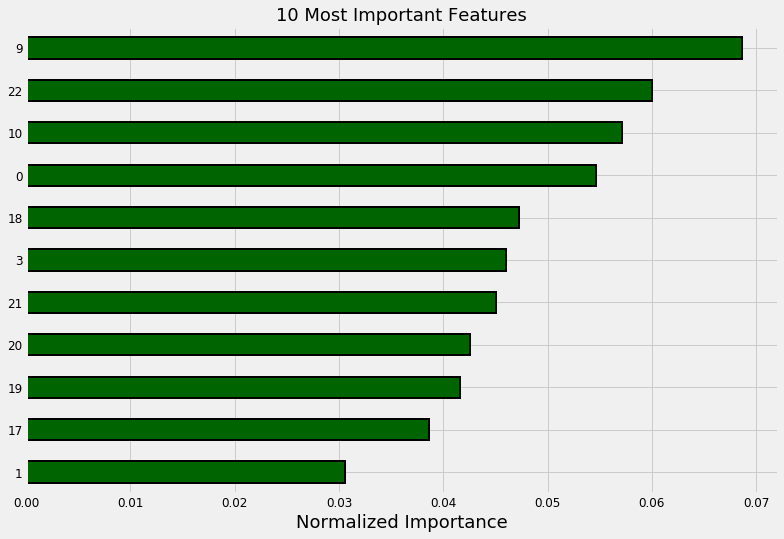

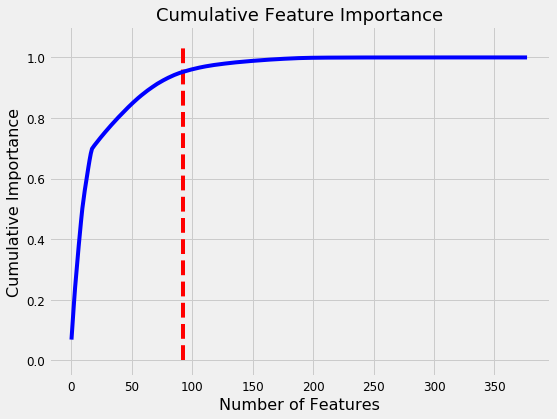

92 features required for 95% of cumulative importance.


In [115]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

In [55]:
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor

In [57]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 5, scoring='mean_squared_error', n_jobs = -1)
    print(f'5 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [ ]:
#model_results = cv_model(train_set, train_labels, SVR(), 
 #                        'SVR', model_results)

In [60]:
model_results = cv_model(train_set, train_labels, 
                         MLPRegressor(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

5 Fold CV Score: -17.0752 with std: 0.4723


In [58]:
model_results = cv_model(train_set, train_labels, 
                         BayesianRidge(), 'Bayesian Ridge', model_results)

5 Fold CV Score: -14.67107 with std: 0.24823


In [ ]:
#model_results = cv_model(train_set, train_labels, 
 #                            KNeighborsClassifier(n_neighbors = 10),
  #                           f'knn-{10}', model_results)

In [59]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), 'GNB', model_results)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Siddi\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\Siddi\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000012AE86F5C00, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Siddi\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\S...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000012AE86F5C00, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Siddi\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\S...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "model_results = cv_model(train_set, train_labels...              GaussianNB(), 'GNB', model_results)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 12, 10, 7, 24, 21, 472510, tzinfo=tzutc()), 'msg_id': '6b7904e35ecf4d6c99ac0943d8ac8ac4', 'msg_type': 'execute_request', 'session': 'e69866b2095c4e088e72ab3906fc9309', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '6b7904e35ecf4d6c99ac0943d8ac8ac4', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'e69866b2095c4e088e72ab3906fc9309']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "model_results = cv_model(train_set, train_labels...              GaussianNB(), 'GNB', model_results)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 12, 10, 7, 24, 21, 472510, tzinfo=tzutc()), 'msg_id': '6b7904e35ecf4d6c99ac0943d8ac8ac4', 'msg_type': 'execute_request', 'session': 'e69866b2095c4e088e72ab3906fc9309', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '6b7904e35ecf4d6c99ac0943d8ac8ac4', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'e69866b2095c4e088e72ab3906fc9309'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "model_results = cv_model(train_set, train_labels...              GaussianNB(), 'GNB', model_results)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 12, 10, 7, 24, 21, 472510, tzinfo=tzutc()), 'msg_id': '6b7904e35ecf4d6c99ac0943d8ac8ac4', 'msg_type': 'execute_request', 'session': 'e69866b2095c4e088e72ab3906fc9309', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '6b7904e35ecf4d6c99ac0943d8ac8ac4', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="model_results = cv_model(train_set, train_labels...              GaussianNB(), 'GNB', model_results)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "model_results = cv_model(train_set, train_labels...              GaussianNB(), 'GNB', model_results)"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("model_results = cv_model(train_set, train_labels...              GaussianNB(), 'GNB', model_results)",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("model_results = cv_model(train_set, train_labels...              GaussianNB(), 'GNB', model_results)",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="model_results = cv_model(train_set, train_labels...              GaussianNB(), 'GNB', model_results)", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-59-de5d78a26a59>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 12c517b3390, executio..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000012C517A2AE0, file "<ipython-input-59-de5d78a26a59>", line 1>
        result = <ExecutionResult object at 12c517b3390, executio..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000012C517A2AE0, file "<ipython-input-59-de5d78a26a59>", line 1>, result=<ExecutionResult object at 12c517b3390, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000012C517A2AE0, file "<ipython-input-59-de5d78a26a59>", line 1>
        self.user_global_ns = {'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ConvergenceWarning': <class 'sklearn.exceptions.ConvergenceWarning'>, 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', 'import pandas as pd\nimport matplotlib.pyplot as ...api as sm\nfrom statsmodels.formula.api import ols', "train_data=pd.read_csv('train.csv')\ntest_data=pd.read_csv('test.csv')", 'train_data_copy=train_data.copy()\ntest_data_copy=test_data.copy()', "train_data_copy['date_column'] = pd.to_datetime(...to_datetime(test_data_copy['first_active_month'])", "train_data_copy['year']=train_data_copy['date_co...y['month']=test_data_copy['date_column'].dt.month", "train_data_copy=train_data_copy.drop(['first_act...drop(['first_active_month','date_column'],axis=1)", "historical_df=pd.read_csv('historical_transactions.csv')", "merchants_df=pd.read_csv('merchants.csv')", "merchants_df['Diff_purchases_3_6']=merchants_df[...'avg_sales_lag6']-merchants_df['avg_sales_lag12']", "merchants_df=merchants_df.drop_duplicates(subset=['merchant_id','merchant_group_id'],keep='first')", "result_hist = pd.merge(historical_df, merchants_df, how='left', on=['merchant_id'])", "result_hist=result_hist.drop(['merchant_category...te_id_y','category_2_y','compare_cities'],axis=1)", "result_hist['compare_cities']=result_hist['city_id_x'].equals(result_hist['city_id_y'])", "result_hist=result_hist.drop(['merchant_category...te_id_y','category_2_y','compare_cities'],axis=1)", 'import gc\ngc.collect()', "result_hist.rename(columns={'city_id_x':'city_id...d','subsector_id_x':'subsector_id'},inplace=True)", "final_hist_trans=result_hist[['card_id','authori...s':'mean'}).reset_index()\nfinal_hist_trans.head()", "final_hist_trans_y=final_hist_trans_y.merge(fina...rename(columns={'merchant_id':'no_of_merchants'})", "final_hist_trans=result_hist[['card_id','merchan..._id').rename(columns={'state_id':'No_Of_states'})", ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'MLPRegressor': <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'Out': {15: 7, 17:            card_id  installments
0  C_ID_0000709...86      0.023148
4  C_ID_000183fdda      1.833333, 23: 528, 24:            card_id  percent_unauth_trans  city_i...                9.329611  

[5 rows x 39 columns], 48: Index(['feature_1', 'feature_2', 'feature_3', 'y...erchants_purchases_lag12'],
      dtype='object'), 49: 0        -0.820283
1         0.392913
2         ...9413
Name: target, Length: 201917, dtype: float64, 52: [2, 4, 11, 12, 15, 23, 24, 25, 26, 27]}, ...}
        self.user_ns = {'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ConvergenceWarning': <class 'sklearn.exceptions.ConvergenceWarning'>, 'DataFrameMapper': <class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', 'import pandas as pd\nimport matplotlib.pyplot as ...api as sm\nfrom statsmodels.formula.api import ols', "train_data=pd.read_csv('train.csv')\ntest_data=pd.read_csv('test.csv')", 'train_data_copy=train_data.copy()\ntest_data_copy=test_data.copy()', "train_data_copy['date_column'] = pd.to_datetime(...to_datetime(test_data_copy['first_active_month'])", "train_data_copy['year']=train_data_copy['date_co...y['month']=test_data_copy['date_column'].dt.month", "train_data_copy=train_data_copy.drop(['first_act...drop(['first_active_month','date_column'],axis=1)", "historical_df=pd.read_csv('historical_transactions.csv')", "merchants_df=pd.read_csv('merchants.csv')", "merchants_df['Diff_purchases_3_6']=merchants_df[...'avg_sales_lag6']-merchants_df['avg_sales_lag12']", "merchants_df=merchants_df.drop_duplicates(subset=['merchant_id','merchant_group_id'],keep='first')", "result_hist = pd.merge(historical_df, merchants_df, how='left', on=['merchant_id'])", "result_hist=result_hist.drop(['merchant_category...te_id_y','category_2_y','compare_cities'],axis=1)", "result_hist['compare_cities']=result_hist['city_id_x'].equals(result_hist['city_id_y'])", "result_hist=result_hist.drop(['merchant_category...te_id_y','category_2_y','compare_cities'],axis=1)", 'import gc\ngc.collect()', "result_hist.rename(columns={'city_id_x':'city_id...d','subsector_id_x':'subsector_id'},inplace=True)", "final_hist_trans=result_hist[['card_id','authori...s':'mean'}).reset_index()\nfinal_hist_trans.head()", "final_hist_trans_y=final_hist_trans_y.merge(fina...rename(columns={'merchant_id':'no_of_merchants'})", "final_hist_trans=result_hist[['card_id','merchan..._id').rename(columns={'state_id':'No_Of_states'})", ...], 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'MLPRegressor': <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'Out': {15: 7, 17:            card_id  installments
0  C_ID_0000709...86      0.023148
4  C_ID_000183fdda      1.833333, 23: 528, 24:            card_id  percent_unauth_trans  city_i...                9.329611  

[5 rows x 39 columns], 48: Index(['feature_1', 'feature_2', 'feature_3', 'y...erchants_purchases_lag12'],
      dtype='object'), 49: 0        -0.820283
1         0.392913
2         ...9413
Name: target, Length: 201917, dtype: float64, 52: [2, 4, 11, 12, 15, 23, 24, 25, 26, 27]}, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
D:\Work\Python\ELO\<ipython-input-59-de5d78a26a59> in <module>()
      1 model_results = cv_model(train_set, train_labels, 
----> 2                          GaussianNB(), 'GNB', model_results)

...........................................................................
D:\Work\Python\ELO\<ipython-input-57-9c80d3e052c0> in cv_model(train=array([[ 0.51684413,  1.63099567, -0.74649878, ....  0.        ,
         0.        ,  0.        ]]), train_labels=0        -0.820283
1         0.392913
2         ...9413
Name: target, Length: 201917, dtype: float64, model=GaussianNB(priors=None), name='GNB', model_results=     cv_mean    cv_std           model
0 -14.671069  0.248227  Bayesian Ridge)
     10 model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])
     11 
     12 def cv_model(train, train_labels, model, name, model_results=None):
     13     """Perform 10 fold cross validation of a model"""
     14     
---> 15     cv_scores = cross_val_score(model, train, train_labels, cv = 5, scoring='mean_squared_error', n_jobs = -1)
     16     print(f'5 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
     17     
     18     if model_results is not None:
     19         model_results = model_results.append(pd.DataFrame({'model': name, 

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in cross_val_score(estimator=GaussianNB(priors=None), X=array([[ 0.51684413,  1.63099567, -0.74649878, ....  0.        ,
         0.        ,  0.        ]]), y=0        -0.820283
1         0.392913
2         ...9413
Name: target, Length: 201917, dtype: float64, groups=None, scoring='mean_squared_error', cv=5, n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in cross_validate(estimator=GaussianNB(priors=None), X=array([[ 0.51684413,  1.63099567, -0.74649878, ....  0.        ,
         0.        ,  0.        ]]), y=0        -0.820283
1         0.392913
2         ...9413
Name: target, Length: 201917, dtype: float64, groups=None, scoring={'score': make_scorer(mean_squared_error, greater_is_better=False)}, cv=KFold(n_splits=5, random_state=None, shuffle=False), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=5, random_state=None, shuffle=False)>
        X = array([[ 0.51684413,  1.63099567, -0.74649878, ....  0.        ,
         0.        ,  0.        ]])
        y = 0        -0.820283
1         0.392913
2         ...9413
Name: target, Length: 201917, dtype: float64
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Dec 10 12:54:29 2018
PID: 10364                Python 3.6.4: C:\Users\Siddi\Anaconda3\python.exe
...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (GaussianNB(priors=None), memmap([[ 0.51684413,  1.63099567, -0.74649878, ... 0.        ,
          0.        ,  0.        ]]), 0        -0.820283
1         0.392913
2         ...9413
Name: target, Length: 201917, dtype: float64, {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([ 40384,  40385,  40386, ..., 201914, 201915, 201916]), array([    0,     1,     2, ..., 40381, 40382, 40383]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (GaussianNB(priors=None), memmap([[ 0.51684413,  1.63099567, -0.74649878, ... 0.        ,
          0.        ,  0.        ]]), 0        -0.820283
1         0.392913
2         ...9413
Name: target, Length: 201917, dtype: float64, {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([ 40384,  40385,  40386, ..., 201914, 201915, 201916]), array([    0,     1,     2, ..., 40381, 40382, 40383]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=GaussianNB(priors=None), X=memmap([[ 0.51684413,  1.63099567, -0.74649878, ... 0.        ,
          0.        ,  0.        ]]), y=0        -0.820283
1         0.392913
2         ...9413
Name: target, Length: 201917, dtype: float64, scorer={'score': make_scorer(mean_squared_error, greater_is_better=False)}, train=array([ 40384,  40385,  40386, ..., 201914, 201915, 201916]), test=array([    0,     1,     2, ..., 40381, 40382, 40383]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method GaussianNB.fit of GaussianNB(priors=None)>
        X_train = memmap([[ 0.73948442, -0.41411283,  0.08051306, ... 0.        ,
          0.        ,  0.        ]])
        y_train = 40384      1.353713
40385     -4.418940
40386   ...9413
Name: target, Length: 161533, dtype: float64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\naive_bayes.py in fit(self=GaussianNB(priors=None), X=array([[ 0.73948442, -0.41411283,  0.08051306, ....  0.        ,
         0.        ,  0.        ]]), y=array([ 1.35371344, -4.41893952, -1.74429039, ...,  0.09349415,
       -4.67658938, -1.85941301]), sample_weight=None)
    180         self : object
    181             Returns self.
    182         """
    183         X, y = check_X_y(X, y)
    184         return self._partial_fit(X, y, np.unique(y), _refit=True,
--> 185                                  sample_weight=sample_weight)
        sample_weight = None
    186 
    187     @staticmethod
    188     def _update_mean_variance(n_past, mu, var, X, sample_weight=None):
    189         """Compute online update of Gaussian mean and variance.

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\naive_bayes.py in _partial_fit(self=GaussianNB(priors=None), X=array([[ 0.73948442, -0.41411283,  0.08051306, ....  0.        ,
         0.        ,  0.        ]]), y=array([ 1.35371344, -4.41893952, -1.74429039, ...,  0.09349415,
       -4.67658938, -1.85941301]), classes=array([-33.21928095, -17.60814651, -17.44192291,... 15.29462075,
        15.99445509,  17.9650684 ]), _refit=True, sample_weight=None)
    345         epsilon = 1e-9 * np.var(X, axis=0).max()
    346 
    347         if _refit:
    348             self.classes_ = None
    349 
--> 350         if _check_partial_fit_first_call(self, classes):
        self = GaussianNB(priors=None)
        classes = array([-33.21928095, -17.60814651, -17.44192291,... 15.29462075,
        15.99445509,  17.9650684 ])
    351             # This is the first call to partial_fit:
    352             # initialize various cumulative counters
    353             n_features = X.shape[1]
    354             n_classes = len(self.classes_)

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\utils\multiclass.py in _check_partial_fit_first_call(clf=GaussianNB(priors=None), classes=array([-33.21928095, -17.60814651, -17.44192291,... 15.29462075,
        15.99445509,  17.9650684 ]))
    316                     "`classes=%r` is not the same as on last call "
    317                     "to partial_fit, was: %r" % (classes, clf.classes_))
    318 
    319         else:
    320             # This is the first call to partial_fit
--> 321             clf.classes_ = unique_labels(classes)
        clf.classes_ = None
        classes = array([-33.21928095, -17.60814651, -17.44192291,... 15.29462075,
        15.99445509,  17.9650684 ])
    322             return True
    323 
    324     # classes is None and clf.classes_ has already previously been set:
    325     # nothing to do

...........................................................................
C:\Users\Siddi\Anaconda3\lib\site-packages\sklearn\utils\multiclass.py in unique_labels(*ys=(array([-33.21928095, -17.60814651, -17.44192291,... 15.29462075,
        15.99445509,  17.9650684 ]),))
     92                          "different numbers of labels")
     93 
     94     # Get the unique set of labels
     95     _unique_labels = _FN_UNIQUE_LABELS.get(label_type, None)
     96     if not _unique_labels:
---> 97         raise ValueError("Unknown label type: %s" % repr(ys))
        ys = (array([-33.21928095, -17.60814651, -17.44192291,... 15.29462075,
        15.99445509,  17.9650684 ]),)
     98 
     99     ys_labels = set(chain.from_iterable(_unique_labels(y) for y in ys))
    100 
    101     # Check that we don't mix string type with number type

ValueError: Unknown label type: (array([-33.21928095, -17.60814651, -17.44192291, ...,  15.29462075,
        15.99445509,  17.9650684 ]),)
___________________________________________________________________________

In [61]:
model = BayesianRidge()

In [62]:
model.fit(train_set, train_labels)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [68]:
test_labels=model.predict(test_set)

In [69]:
submission_df.target = submission_df.target.round(2)

In [70]:
submission_df.to_csv('submission_2.csv',index=False)

In [71]:
from sklearn.feature_selection import RFECV

In [73]:
estimator = RandomForestRegressor(random_state = 10, n_estimators = 100,  n_jobs = -1)

In [74]:
selector = RFECV(estimator, step = 1, cv = 3, scoring= 'mean_squared_error', n_jobs = -1)

In [ ]:
selector.fit(train_set, train_labels)

In [54]:
result_hist.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,Diff_purchases_3_6,Diff_purchases_6_12,Diff_sales_3_6,Diff_sales_6_12
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,...,1.114135,6.0,1.19,1.156844,12.0,Y,0.031684,-0.042708,0.06,-0.05
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,...,1.058605,6.0,1.05,1.062087,12.0,Y,0.006534,-0.003482,0.00,0.01
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,...,0.967058,6.0,0.97,0.956668,12.0,Y,-0.007595,0.010390,0.00,0.01
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,...,0.897406,6.0,0.86,0.864394,12.0,Y,-0.156037,0.033012,-0.12,0.02
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,...,1.114135,6.0,1.19,1.156844,12.0,Y,0.031684,-0.042708,0.06,-0.05
